# CIS6800: Project 2: YOLO
### Due:
* Part A - Sept. 18 at 11:59 p.m.
* Part B - Sept. 25 at 11:59 p.m.

### Instructions:
* Part A consists of parts 1-4 and is due on September 18th at 11:59 p.m. EDT.
* Part B consists of parts 5-8 and is due on September 25th at 11:59 p.m. EDT.
* As the autograder uses the definitions for functions and classes you submit,
please do not modify the name of any function or class provided.
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.

## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you donâ€™t need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} = 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} + 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} + 
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} + 
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} + 
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Code

In [ ]:
!pip install pytorch_lightning &> /dev/null

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
import matplotlib.patches as patches
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Dataset
import torchvision
from torchvision import transforms

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

### Mounting Google Drive


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# folder_path = "/content/drive/MyDrive/Colab Notebooks/CIS 6800/HW2/"
# folder_path = "/content/drive/MyDrive/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Use this function to import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

images = load_data(folder_path + 'images.npz')
raw_labels = load_data(folder_path + 'labels.npz')


### Helper Functions

In [ ]:
#Visualizing dataset
def plot_image_with_boxes(image,label):
  
  # plt.imshow(image)
  fig, ax = plt.subplots(figsize = (8,8))
  
  mapping = {0:"r",1:"b",2:"g"}
  label_mapping = {0 : "Person", 1 : "Traffic Light", 2 : "Car"}
  ax.imshow(image)
  for box in label:
    x1 = box[1]
    y1 = box[2]
    x2 = box[3]
    y2 = box[4]

    width = x2-x1
    height = y2-y1
    # print(height)
    rect = patches.Rectangle((x1, y1), width, height, linewidth=3, edgecolor=mapping[box[0]], facecolor='none')
    
    props = dict(boxstyle='round', facecolor=mapping[box[0]], alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(x1, y1-4, label_mapping[box[0]], fontsize=10, color="w",
        verticalalignment='top', bbox=props)
    ax.add_patch(rect)
  plt.show()

import random
idx = random.randint(0, len(raw_labels))
# idx = 4192
print(idx)
# plot_image_with_boxes(images[idx], raw_labels[idx])
# print(raw_labels[idx])

#Function to create the dataset for calculating precision and recall

def create_data_for_precision_recall(new_model):
#Creating the dataset

  # from fastprogress import progress_bar

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(0.5,0.5)
      ]
  )

  processed_labels = np.asarray([process_labels([raw_labels[i]]) for i in range(len(raw_labels))])
  batch_size = 64
  class YOLODataset(Dataset):
      """TensorDataset with support of transforms.
      """
      def __init__(self, tensors, transform=None):
          # assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
          self.tensors = tensors
          self.transform = transform

      def __getitem__(self, index):
          x = self.tensors[0][index]
          if self.transform:
              x = self.transform(x)
          y = self.tensors[1][index]

          return x, y

      def __len__(self):
          # print(self.tensors[0].shape[0])
          return self.tensors[0].shape[0]

  # class YOLO

  train_proportion = 0.3
  train_idx = int(len(images) * train_proportion)
  train_dataset = YOLODataset(tensors=(images[:train_idx], processed_labels[:train_idx]), transform = transform)
  train_loader = DataLoader(train_dataset, batch_size = batch_size)

  
  #Forming the entire validation set
  preds_all = []
  gts_all = []

  max_conf = 0
  # for images_batch, labels_batch in progress_bar(train_loader):
  for images_batch, labels_batch in train_loader:
    preds = new_model(images_batch)
    # print(torch.max(preds[:,:,:,0]))
    max_conf = max(max_conf,torch.max(preds[:,:,:,0]).cpu().detach().item() )
    preds_all.extend(preds.cpu().detach().numpy())
    gts_all.extend(labels_batch.cpu().detach().numpy())
  return preds_all, gts_all, max_conf

5923


In [ ]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
#NOTE: Use the last label for a particular grid cell if multiple bounding boxes in one grid
def process_labels(raw_labels):

    raw_labels = raw_labels[0]
    img_dim = 128
    grid_size = 16
    labels = np.zeros((8,8,8), dtype=np.float64)
    for box in raw_labels:
      x1, y1, x2, y2 = box[1], box[2], box[3], box[4]

      pc = 1.0
      x_c = (x1+x2)/2.0
      y_c = (y1+y2)/2.0
      w = x2 - x1
      # print(w)
      rel_w = w/img_dim
      # print(rel_w)
      h = y2 - y1
      rel_h = h/img_dim
      p_onehot = [0.0 for i in range(3)]
      p_onehot[int(box[0])] = 1.0

      y_rel_grid = x_c/grid_size
      y_coord = int(y_rel_grid)
      x_rel_value = y_rel_grid - y_coord

      x_rel_grid = y_c/grid_size
      x_coord = int(x_rel_grid)
      y_rel_value = x_rel_grid - x_coord

      process_label = np.asarray([1.0, x_rel_value, y_rel_value, rel_w, rel_h] + p_onehot)
      # print(np.around(process_label,3))
      # print(x_coord, ",",y_coord)
      labels[x_coord][y_coord] = process_label
      # print("\nLABEL:")
      # print(np.around(labels[3,:,:],3))
    # labels = torch.permute(torch.tensor(labels),(2,1,0)).numpy() #NEW CHANGE
      # print(box,":", process_label)
      # print("-"*100)
    return labels

labels = process_labels([raw_labels[4192]])
# np.transpose(labels,(2,1,0))
# np.around(labels[2,:,:],3)

In [ ]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128):
    # labels = torch.permute(torch.tensor(labels),(2,1,0)).numpy() #NEW CHANGE
    raw_labels = list()
    grid_size = 16.0
    for i in range(labels.shape[0]):
      for j in range(labels.shape[1]):
        if labels[i][j][0] > 0:
          label = labels[i][j]
          box_class = np.argmax(label[5:])
          x_center = (label[1] + j) * grid_size
          y_center = (label[2]  + i) * grid_size
          w_half = (label[3] * img_dim)/2.0
          h_half = (label[4] * img_dim)/2.0

          x1 = x_center - w_half
          x2 = x_center + w_half 
          y1 = y_center - h_half
          y2 = y_center + h_half

          raw_label = [float(box_class),x1,y1,x2,y2]
          # print(float(box_class),x1,y1,x2,y2)
          raw_labels.append(raw_label)
    raw_labels = np.asarray(raw_labels)
    return raw_labels

In [ ]:
# raw_labels[4192]

In [ ]:
# reconstruct_raw_labels(process_labels([raw_labels[4192]]))

## Loss Experimentation

In [ ]:

def calculate_iou(output, target):
      # print("IOU:>",output.shape,target.shape)
      grid_size = 16
      image_size = 128
      #Taking dimension in pixel space instead of grid space
      op_x1, op_x2 = ((output[:,:,:,1] * grid_size) - (0.5*output[:,:,:,3]*image_size) ), ((output[:,:,:,1] * grid_size) + (0.5*output[:,:,:,3]*image_size))
      trg_x1, trg_x2 = ((target[:,:,:,1] * grid_size) - (0.5*target[:,:,:,3]*image_size)), ((target[:,:,:,1] * grid_size) + (0.5*target[:,:,:,3]*image_size))
      op_y1, op_y2 = ((output[:,:,:,2] * grid_size) - (0.5*output[:,:,:,4]*image_size)), ((output[:,:,:,2] * grid_size) + (0.5*output[:,:,:,4]*image_size))
      trg_y1, trg_y2 = ((target[:,:,:,2] * grid_size) - (0.5*target[:,:,:,4]*image_size)), ((target[:,:,:,2] * grid_size) + (0.5*target[:,:,:,4]*image_size))

      # min(op_x2,trg_x2) - max(op_x1,trg_x1)
      intersect_width = torch.minimum(op_x2,trg_x2) - torch.maximum(op_x1, trg_x1)
      # min(op_y2,trg_y2) - max(op_y1,trg_x2)
      intersect_height = torch.minimum(op_y2,trg_y2) - torch.maximum(op_y1, trg_y1)

      intersection = torch.clamp(intersect_width,0) * torch.clamp(intersect_height,0)
      union = torch.clamp(((output[:,:,:,3] * image_size * output[:,:,:,4] * image_size) + (target[:,:,:,3] * image_size * target[:,:,:,4] * image_size) - intersection),1e-6)
      IOU = intersection/union
      return IOU

def yolo_loss(output, target):
      # print("YOLO LOSS:",output.shape, target.shape)
      
      lambda_noobj = 0.5
      lambda_coord = 5
      # output, target = torch.permute(output,(0,3,2,1)), torch.permute(target, (0,3,2,1))
      # print("OUTPUT:",output[:,:,:,0])
      # print("TARGET:",target[:,:,:,0])
      batch_size = output.shape[0]
      obj_mask = target[:,:,:,0] 
      neg_obj_mask = 1 - obj_mask
      coord_loss = lambda_coord * torch.sum(obj_mask * (torch.square(output[:,:,:,1] - target[:,:,:,1]) + torch.square(output[:,:,:,2] - target[:,:,:,2])))
      dimension_loss = lambda_coord * torch.sum(obj_mask * (torch.square(output[:,:,:,3]**0.5 - target[:,:,:,3]**0.5) + torch.square(output[:,:,:,4]**0.5 - target[:,:,:,4]**0.5)))

      IOU = calculate_iou(output, target)
      box_confidence_pred = output[:,:,:,0] 
      box_confidence_trg = target[:,:,:,0] 

      obj_box_confidence_loss = torch.sum(obj_mask * torch.square(box_confidence_pred - (box_confidence_trg * IOU)))
      no_obj_box_confidence_loss = lambda_noobj * (torch.sum(neg_obj_mask * torch.square(box_confidence_pred - (box_confidence_trg ))))                     
      pred_class_loss = torch.sum(obj_mask * torch.sum(torch.square(output[:,:,:,-3:] - target[:,:,:,-3:]), -1))
      
      loss = (coord_loss + dimension_loss + obj_box_confidence_loss + no_obj_box_confidence_loss + pred_class_loss)/batch_size
      # print(loss)
      return loss

# YOLO Model

In [ ]:
import torch.nn.functional as F

class YOLO(pl.LightningModule):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU())
      self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU())
      self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU())
      self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU())
      self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU())
      self.conv6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(1024),
            nn.ReLU())
      self.trans_conv7 = nn.Sequential(
            nn.ConvTranspose2d(1024, 256, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU())
      self.trans_conv8 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride = 2, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU())
      self.conv9 = nn.Conv2d(64, 8, kernel_size=3, stride = 1, padding = 1)

      self.training_losses = []
      self.val_losses = []
      self.val_losses_epoch = []
      self.train_losses_epoch = []
      self.val_epoch = 0
      self.map_val_step = []
      self.map_epoch = []
      self.model_url = "https://drive.google.com/uc?id=1-5CS3jxJsOPBavjPJJ4-59RW-rjWKtLk&export=download&confirm=t&uuid=590a5732-1a04-4a21-98da-3d6d8961711c"

    def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.trans_conv7(x)
      x = self.trans_conv8(x)
      x = self.conv9(x)
      # x = F.log_softmax(x, dim=1)
      x = torch.sigmoid(x)
      return x

    def calculate_iou(self, output, target):
      
      grid_size = 16
      image_size = 128
      #Taking dimension in pixel space instead of grid space
      op_x1, op_x2 = ((output[:,:,:,1] * grid_size) - (0.5*output[:,:,:,3]*image_size) ), ((output[:,:,:,1] * grid_size) + (0.5*output[:,:,:,3]*image_size))
      trg_x1, trg_x2 = ((target[:,:,:,1] * grid_size) - (0.5*target[:,:,:,3]*image_size)), ((target[:,:,:,1] * grid_size) + (0.5*target[:,:,:,3]*image_size))
      op_y1, op_y2 = ((output[:,:,:,2] * grid_size) - (0.5*output[:,:,:,4]*image_size)), ((output[:,:,:,2] * grid_size) + (0.5*output[:,:,:,4]*image_size))
      trg_y1, trg_y2 = ((target[:,:,:,2] * grid_size) - (0.5*target[:,:,:,4]*image_size)), ((target[:,:,:,2] * grid_size) + (0.5*target[:,:,:,4]*image_size))

      # min(op_x2,trg_x2) - max(op_x1,trg_x1)
      intersect_width = torch.minimum(op_x2,trg_x2) - torch.maximum(op_x1, trg_x1)
      # min(op_y2,trg_y2) - max(op_y1,trg_x2)
      intersect_height = torch.minimum(op_y2,trg_y2) - torch.maximum(op_y1, trg_y1)

      intersection = torch.clamp(intersect_width,0) * torch.clamp(intersect_height,0)
      union = torch.clamp(((output[:,:,:,3] * image_size * output[:,:,:,4] * image_size) + (target[:,:,:,3] * image_size * target[:,:,:,4] * image_size) - intersection),1e-6)
      IOU = intersection/union
      return IOU

    def yolo_loss(self, output, target):
      lambda_noobj = 0.5
      lambda_coord = 5
      # output, target = torch.permute(output,(0,3,2,1)), torch.permute(target, (0,3,2,1))
      batch_size = output.shape[0]
      obj_mask = target[:,:,:,0] 
      neg_obj_mask = 1 - obj_mask
      coord_loss = lambda_coord * torch.sum(obj_mask * (torch.square(output[:,:,:,1] - target[:,:,:,1]) + torch.square(output[:,:,:,2] - target[:,:,:,2])))
      dimension_loss = lambda_coord * torch.sum(obj_mask * (torch.square(output[:,:,:,3]**0.5 - target[:,:,:,3]**0.5) + torch.square(output[:,:,:,4]**0.5 - target[:,:,:,4]**0.5)))

      # IOU = self.calculate_iou(output, target)
      IOU = self.calculate_iou(output, target)
      box_confidence_pred = output[:,:,:,0] 
      box_confidence_trg = target[:,:,:,0] 

      obj_box_confidence_loss = torch.sum(obj_mask * torch.square(box_confidence_pred - (box_confidence_trg * IOU)))
      no_obj_box_confidence_loss = lambda_noobj * (torch.sum(neg_obj_mask * torch.square(box_confidence_pred - (box_confidence_trg * IOU))))                     
      pred_class_loss = torch.sum(obj_mask * torch.sum(torch.square(output[:,:,:,-3:] - target[:,:,:,-3:]), -1))
      
      loss = (coord_loss + dimension_loss + obj_box_confidence_loss + no_obj_box_confidence_loss + pred_class_loss)/batch_size
      # print(loss)
      return loss

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        train_loss = self.yolo_loss(y_pred, y)
        # logs metrics for each training_step,and the average across the epoch, to the progress bar and logger
        self.log("train_loss", train_loss, prog_bar = True, logger=True)#, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.training_losses.append(train_loss.item())
        return train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        val_loss = self.yolo_loss(y_pred, y)
        self.log("val_loss", val_loss, prog_bar = True, logger=True)#on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.val_losses.append(val_loss.item())

        if self.val_epoch % 5 == 0:
          max_confidence = torch.max(y_pred[:,:,:,0]).detach().cpu().numpy()
          
          map_val_step_val = mean_average_precision(predictions = y_pred.cpu().detach().numpy(), targets=y.cpu().detach().numpy(), max_confidence=max_confidence,
                                                min_confidence_threshold = 0.6, num_confidence_intervals = 30)
          self.map_val_step.append(map_val_step_val)
        return val_loss

    def training_epoch_end(self, outputs):
      if outputs:
        self.train_losses_epoch.append(torch.tensor([x['loss'] for x in outputs]).mean().item())

    def validation_epoch_end(self, outputs):
      # print("Validation Outputs:")
      # print(outputs)
      # print("Val epoch:", self.val_epoch)
      if outputs:
        self.val_losses_epoch.append(torch.tensor(outputs).mean().item())

      if self.val_epoch % 5 == 0:
        print("Val epoch:", self.val_epoch)
        print(self.map_val_step,sum(self.map_val_step),"Length:",len(self.map_val_step))
        print("MAP:",sum(self.map_val_step)/len(self.map_val_step))
        self.map_epoch.append(sum(self.map_val_step)/len(self.map_val_step))
        self.map_val_step = []

      self.val_epoch += 1

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=10e-3)
        return optimizer

    def load_from_url():
      
      return YOLO.load_from_checkpoint("https://drive.google.com/uc?id=1-5CS3jxJsOPBavjPJJ4-59RW-rjWKtLk&export=download&confirm=t&uuid=590a5732-1a04-4a21-98da-3d6d8961711c")

    def inference(self, images, labels):
      with torch.no_grad():
        preds_all = []
        images = torch.from_numpy(images)/255.0
        images = (images - 0.5)/0.5
        images = images.permute(0,3,1,2)

        # for i,(images, labels) in enumerate(images):
        preds = self(images)
        preds_all.extend(preds.cpu().detach().numpy())

        preds_test = low_confidence_suppression(np.array(preds_all))


        preds_nms = []
        for i,pred in enumerate(preds_test):
          nms_pred = non_max_suppression(pred)
          if len(nms_pred) == 0:
            # preds_nms.append(np.zeros((1,6)))
            preds_nms.append(np.zeros(1,6))
          else:
            preds_nms.append(nms_pred)
      return preds_nms
             

model = YOLO().to(device)

In [ ]:
# checkpoint_callback = pl_callbacks.ModelCheckpoint()
# tb_logger = pl_loggers.TensorBoardLogger(save_dir = "logs")

# trainer = pl.Trainer(gpus=1, logger=tb_logger, max_epochs=35, callbacks=[checkpoint_callback])
# trainer.fit(model, train_loader)

In [ ]:
model = YOLO.load_from_url()

In [ ]:
model.inference(images[:1],raw_labels[:1])

[array([[  0.        ,   0.63608098, 119.80744457,  47.73048329,
         122.81635952,  55.69567084],
        [  2.        ,   0.88494802,  79.74738693,  47.73192501,
          94.74608517,  62.79116058],
        [  2.        ,   0.81701273, 100.95003796,  48.36008978,
         110.03772068,  60.55296469]])]

In [ ]:
# idx = 4
# for i,(image, label) in enumerate(train_loader):
#   image_test = image[0]
#   raw_label_test = reconstruct_raw_labels(label[0])
#   pred = model(image)[0]
#   pred[pred[:,:,0]<0.5] = 0
#   raw_label_pred = reconstruct_raw_labels(pred.detach().numpy())
#   if i>idx:
#     break
  
# plot_image_with_boxes(image_test[0], raw_label_pred) #Can convert to 0 to 255 range

# Low Confidence Supression and NMS:

In [ ]:
#Function to suprress bounding boxes with lesser probability of objectness than the threshold
def low_confidence_suppression(label, confidence_threshold = 0.6):
  #Can have one image or a batch of images
    if len(label.shape) == 4:
      label[label[:,:,:,0]<=confidence_threshold] = 0
    elif len(label.shape) == 3:
      label[label[:,:,0]<=confidence_threshold] = 0
    else:
      raise ValueError("Invalid number of dimnesions in label.")
    return label

#Function to supress bounding boxes of the same class with greater IOU than the threshold
def non_max_suppression(label, nms_iou_threshold = 0.5):
    #Expects inputs for one image only
    all_boxes = []
    for cls in [0,1,2]:
      # print(cls)
      sorted_cls_bbox = sort_bbox_by_confidence(get_class_boxes(reconstruct_raw_labels_nms(label), cls))
      # print(sorted_cls_bbox)
      all_boxes += perform_nms_per_class(sorted_cls_bbox, nms_iou_threshold)
    return np.array(all_boxes)


#Function to construct raw labels from the processed labels for the purpose of NMS
def reconstruct_raw_labels_nms(labels, img_dim=128):
    # labels = torch.permute(torch.tensor(labels),(2,1,0)).numpy() #NEW CHANGE
    raw_labels = list()
    grid_size = 16.0
    for i in range(labels.shape[0]):
      for j in range(labels.shape[1]):
        if labels[i][j][0] > 0:
          label = labels[i][j]
          box_class = np.argmax(label[5:])
          x_center = (label[1] + j) * grid_size
          y_center = (label[2]  + i) * grid_size
          w_half = (label[3] * img_dim)/2.0
          h_half = (label[4] * img_dim)/2.0

          x1 = x_center - w_half
          x2 = x_center + w_half 
          y1 = y_center - h_half
          y2 = y_center + h_half

          raw_label = [float(box_class),label[0],x1,y1,x2,y2]
          # print(float(box_class),x1,y1,x2,y2)
          raw_labels.append(raw_label)
    raw_labels = np.asarray(raw_labels)
    return raw_labels


#Function to get all bounding boxes of a particular class
def get_class_boxes(bounding_boxes, cls):
  if len(bounding_boxes) != 0:
    return bounding_boxes[bounding_boxes[:,0] == cls]
  else:
    return np.array([])

#Function to sort bounding boxes of the same class in descending order of probability of objectness
def sort_bbox_by_confidence(bboxes):
  #Confidence stored at second index [:,1]
  if len(bboxes) != 0:
    return bboxes[np.argsort(-bboxes[:,1], -1)]
  else:
    return bboxes

def IOU_NMS(output, target):
  op_x1, op_y1, op_x2, op_y2 = output[2],output[3],output[4],output[5]
  trg_x1, trg_y1, trg_x2, trg_y2 = target[2],target[3],target[4],target[5]

  intersect_width = np.minimum(op_x2,trg_x2) - np.maximum(op_x1, trg_x1)
  intersect_height = np.minimum(op_y2,trg_y2) - np.maximum(op_y1, trg_y1)

  intersection = np.clip(intersect_width,0, float("inf")) * np.clip(intersect_height,0, float("inf"))
  union = np.clip(((op_x2 - op_x1) * (op_y2 - op_y1)) + ((trg_x2 - trg_x1) * (trg_y2 - trg_y1)),1e-6,float("inf")) - intersection
  IoU = intersection/union
  return IoU

#Function to return non-overlapping bounding box of same class after nms
def perform_nms_per_class(sorted_cls_bbox, nms_iou_threshold = 0.5):
  
  sorted_bbox_list = list(sorted_cls_bbox)
  # print("Sorted bbox list:", sorted_bbox_list)
  # print()
  if not sorted_bbox_list:
    return []

  nms_boxes = []
  queue = [sorted_bbox_list.pop(0)]

  while queue:
    bbox = queue.pop(0)
    nms_boxes.append(np.clip(bbox,0,float("inf")))
    # print("NMS box:",nms_boxes)
    non_overlapping_bbox = []
    for target in sorted_bbox_list:
      # print("trg",target)
      if IOU_NMS(bbox,target) < nms_iou_threshold:
        non_overlapping_bbox.append(target)
    sorted_bbox_list = non_overlapping_bbox
    if sorted_bbox_list:
      queue.append(sorted_bbox_list.pop(0))

  return nms_boxes

# Precision, Recall and MAP

In [ ]:
#Calculating IOU for precision and recall
def IOU_PR(pred_lcs_nms_raw_class,label_raw_class, iou_threshold = 0.5):
  pred_x1 = pred_lcs_nms_raw_class[:,2].reshape(-1,1)
  pred_y1 = pred_lcs_nms_raw_class[:,3].reshape(-1,1)
  pred_x2 = pred_lcs_nms_raw_class[:,4].reshape(-1,1)
  pred_y2 = pred_lcs_nms_raw_class[:,5].reshape(-1,1)

  trg_x1 = label_raw_class[:,1].reshape(-1,1)
  trg_y1 = label_raw_class[:,2].reshape(-1,1)
  trg_x2 = label_raw_class[:,3].reshape(-1,1)
  trg_y2 = label_raw_class[:,4].reshape(-1,1)
  pred_w = np.clip(pred_x2-pred_x1,0,float("inf"))
  pred_h = np.clip(pred_y2-pred_y1,0,float("inf"))
  pred_area = pred_w * pred_h
  trg_w = np.clip(trg_x2-trg_x1,0,float("inf"))
  trg_h = np.clip(trg_y2-trg_y1,0,float("inf"))
  trg_area = trg_w * trg_h
  intersect_width = np.minimum(pred_x2, trg_x2.T) - np.maximum(pred_x1, trg_x1.T)
  intersect_height = np.minimum(pred_y2, trg_y2.T) - np.maximum(pred_y1, trg_y1.T)
  intersect_width[intersect_width < 0] = 0
  intersect_height[intersect_height < 0] = 0
  intersect_area = intersect_width * intersect_height
  union_area = (pred_area + trg_area.T ) - intersect_area
  union_area = np.clip(union_area, 1e-6, float("inf"))

  iou = intersect_area/union_area
  iou = np.where(iou > iou_threshold,1,0)
  return iou

def precision_recall_curve(predictions, targets, max_confidence, min_confidence_threshold = 0.6, num_confidence_intervals = 30):
  # print("Num_images:",len(predictions))
  '''
  Args:
    predictions: bx8x8x8 prediction by the model
    targets: bx8x8x8 original GT
  '''
  confidence_values = np.linspace(min_confidence_threshold, max_confidence, num_confidence_intervals)

  precision_values = {0:[],1:[],2:[]}
  recall_values = {0:[],1:[],2:[]}

  for confidence_value in confidence_values:
    # print("Confidence:",confidence_value)
    total_tp_p = {0:0,1:0,2:0}
    total_tp_r = {0:0,1:0,2:0}
    total_gt = {0:0,1:0,2:0}
    total_bbox = {0:0,1:0,2:0}
    # print(precision_values, recall_values)
    preds_low_conf_supr = low_confidence_suppression(predictions, confidence_threshold = confidence_value)

    for i in range(len(targets)):
      # print()
      # print(f"Image {i}")
    
      label = targets[i]
      pred = preds_low_conf_supr[i]
      label_raw = reconstruct_raw_labels(label)
      pred_nms_raw =  non_max_suppression(pred)

      for pred_class in [0,1,2]:
        if len(pred_nms_raw) != 0:
          iou_class = IOU_PR(pred_nms_raw[pred_nms_raw[:,0] == pred_class], label_raw[label_raw[:,0] == pred_class], iou_threshold=0.5)
        else:
          iou_class = np.empty([len(pred_nms_raw),len(label_raw[label_raw[:,0] == pred_class])])
          
        # print(iou_class)
        # print(iou_class.shape)
        # if len(iou_class):
        # print(iou_class)
        TP_p = np.sum(np.where(np.sum(iou_class, -1)>=1,1,0))
        TP_r = np.sum(np.where(np.sum(iou_class,0)>=1,1,0))
        all_bbox = iou_class.shape[0]
        all_gts = iou_class.shape[1]

        total_tp_p[pred_class] += TP_p
        total_tp_r[pred_class] += TP_r
        total_gt[pred_class] += all_gts
        total_bbox[pred_class] += all_bbox
        
      
      # print(total_tp_r,total_tp_p,total_gt, total_bbox)
    for pred_class in [0,1,2]:
      if total_bbox[pred_class] != 0:
        precision_class = total_tp_p[pred_class] / total_bbox[pred_class]
      else:
        precision_class = 0.0
      
      if total_gt[pred_class] != 0:
        recall_class = total_tp_r[pred_class] / total_gt[pred_class]
      else:
        recall_class = 0.0

      precision_values[pred_class].append(precision_class)
      recall_values[pred_class].append(recall_class)
      # print("Class:", pred_class, "Precision:", precision_class, "Recall:", recall_class)
    # print("-"*50)
  return recall_values, precision_values

def average_precision(recall_values, precision_values, target_class):
    
    recall_class = np.array(recall_values[target_class])
    sort_idx = np.argsort(recall_class)
    precision_class = np.array(precision_values[target_class])[sort_idx]
    recall_class = recall_class[sort_idx]
    average_precision = 0
    for i in range(len(precision_class)-1):
      area_sq = (recall_class[i+1] - recall_class[i]) * max(precision_class[i+1], precision_class[i])
      average_precision += area_sq
    return average_precision

def mean_average_precision(predictions, targets, max_confidence, min_confidence_threshold = 0.6, num_confidence_intervals = 30):
    average_precision_dict = {}
    recall_values, precision_values = precision_recall_curve(predictions, targets, max_confidence, min_confidence_threshold, num_confidence_intervals)
    for target_class in [0,1,2]:
      average_precision_class = average_precision(recall_values, precision_values, target_class)
      average_precision_dict[target_class] = average_precision_class
    # print(average_precision_dict)
    mean_average_precision = sum(average_precision_dict.values()) / len(average_precision_dict)
    return mean_average_precision

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light).
  1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)
  2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)
  3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

## 1. 

In [ ]:
chosen_image_idx = 8948 
# chosen_image_idx = random.randint(0, len(raw_labels))
print(chosen_image_idx)

8948


### 1.1

Image Size is 128 x 128 x 3. The image selected here contains all the labels-cars, pedestrians and traffic lights. The selected index from images is 4192. So, Green bounding boxes are shown around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic light as shown below

8948


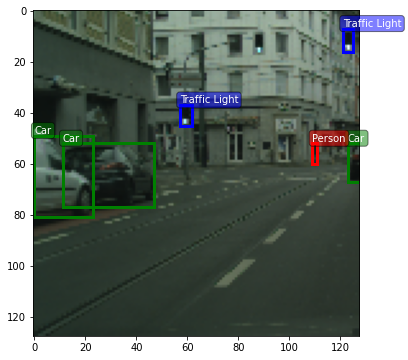

In [ ]:
# Show the chosen image with ground truth bounding boxes visualized.
#Visualizing dataset
# Q1.1.

def plot_image_with_boxes(image,label, vmin = None, vmax = None):
  
  # plt.imshow(image)
  box = raw_labels[0][1]
  fig, ax = plt.subplots(figsize = (6,6))
  
  mapping = {0:"r",1:"b",2:"g"}
  label_mapping = {0 : "Person", 1 : "Traffic Light", 2 : "Car"}
  ax.imshow(image, vmin = vmin, vmax = vmax)
  for box in label:
    x1 = box[1]
    y1 = box[2]
    x2 = box[3]
    y2 = box[4]

    width = x2-x1
    height = y2-y1
    # print(height)
    rect = patches.Rectangle((x1, y1), width, height, linewidth=3, edgecolor=mapping[box[0]], facecolor='none')
    
    props = dict(boxstyle='round', facecolor=mapping[box[0]], alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(x1, y1-4, label_mapping[box[0]], fontsize=10, color="w",
        verticalalignment='top', bbox=props)
    ax.add_patch(rect)
  plt.show()

import random
# idx = random.randint(0, len(raw_labels))
idx = chosen_image_idx
print(idx)
plot_image_with_boxes(images[idx], raw_labels[idx])
# print(raw_labels[idx])

### 1.2

The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box. This section focuses on converting the image labels to an 8x8x8 representation and visualizing each channel of the processed labels. We consider a  16×16  image patch as a grid cell and thus divide the full image into  8×8  patches in the 2D spatial dimension. The visualization generated below is labeled by the visualization of each channel with the associated channel number and visualized value. 

For simplified YOLO, we only use one anchor box, where there is one anchor per grid cell and for each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car) as visualized.

Num objects: 6


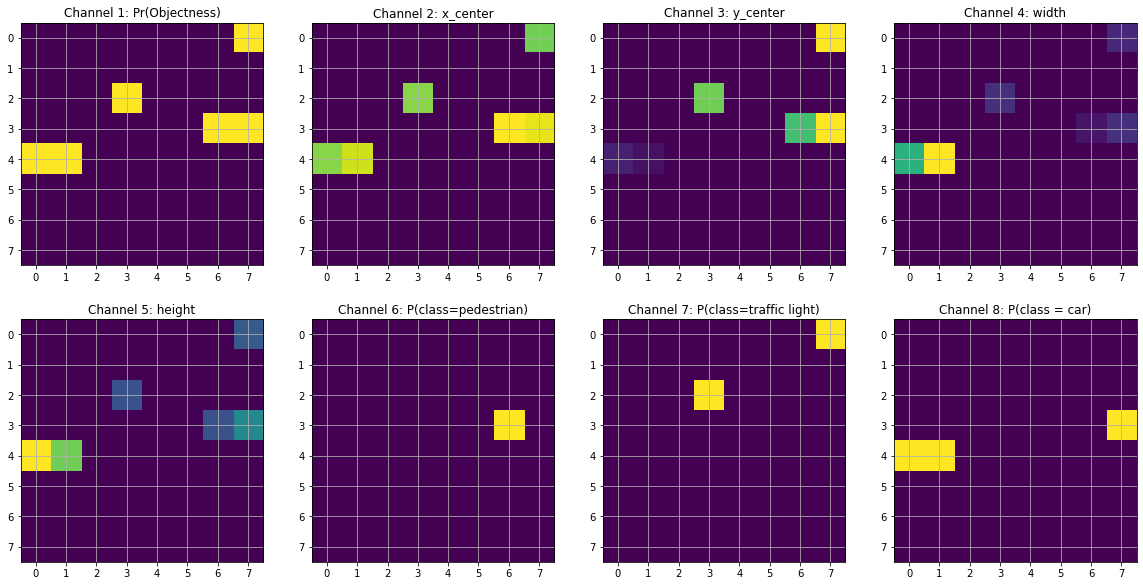

In [ ]:
# Visualize the 8x8x8 representation.
print("Num objects:",len(raw_labels[chosen_image_idx]))
processed_label = process_labels([raw_labels[chosen_image_idx]])
# processed_label_2 = torch.permute(torch.tensor(processed_label),(2,1,0)).numpy()

def visualize_processed_label(processed_label):
  channel_mappings = {0:"Pr(Objectness)",1:"x_center",2:"y_center",3:"width",4:"height",5:"P(class=pedestrian)",6:"P(class=traffic light)",7:"P(class = car)"}
  f, axarr = plt.subplots(2,4, figsize = (20,10))
  num_channels = processed_label.shape[-1]

  for i in range(num_channels):
    coordinates = (i//4,i%4)
    axarr[coordinates].grid()
    # axarr[coordinates].set_xlim(xmin = 0)
    axarr[coordinates].set_xticks([i for i in range(num_channels)])
    # axarr[coordinates].set_ylim(ymin = 0)
    axarr[coordinates].set_yticks([i for i in range(num_channels)])
    axarr[coordinates].imshow(processed_label[:,:,i], cmap = "viridis")
    axarr[coordinates].set_title(f"Channel {i+1}: {channel_mappings[i]}")
    

  plt.show()

visualize_processed_label(processed_label)
# visualize_processed_label(processed_label_2)

### 1.3

This section focuses on converting back the previously converted image labels (8x8x8representation) back to its original representation and the image is visualized with the bounding boxes.

Num objects after processing raw labels: 6


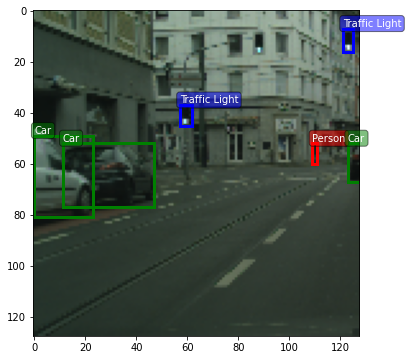

In [ ]:
# Convert back to the original representation (test cases below should pass).
raw_label_from_processed = reconstruct_raw_labels(processed_label)
print("Num objects after processing raw labels:",len(raw_label_from_processed))
plot_image_with_boxes(images[chosen_image_idx], raw_label_from_processed)

2. Implement the loss function. (3%)

--> Implemented the loss function and included as a method of the PyTorch Lightning Module YOLO.

--> The loss function composes of:


*  Localization Loss (errors between the predicted boundary box and the ground truth).
*  Classification Loss
*  Confidence Loss

Loss Formula and Terms

$$ \text{Loss} = 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} + 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} + 
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} + 
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} + 
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$


* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

--> Hyperparameters


$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. For this project we have set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

-->Block Diagram



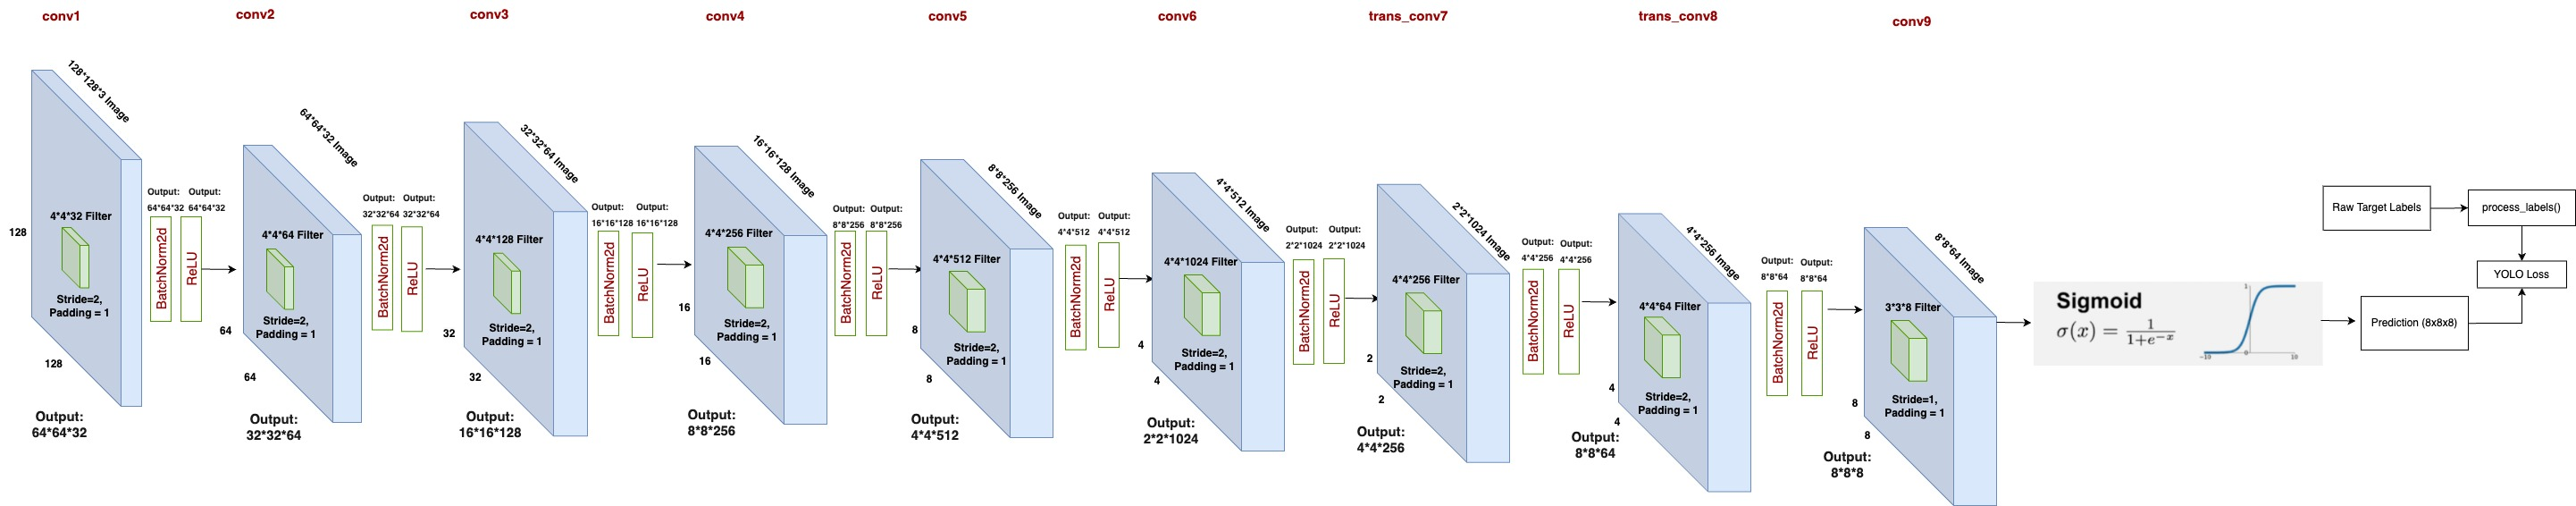

The network diagram is also uploaded here- https://drive.google.com/file/d/1UMXk6uA6fxe9fpsfrwfmOLEqNqhNG8hG/view?usp=sharing

This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$. The network has 9 convolutional layers
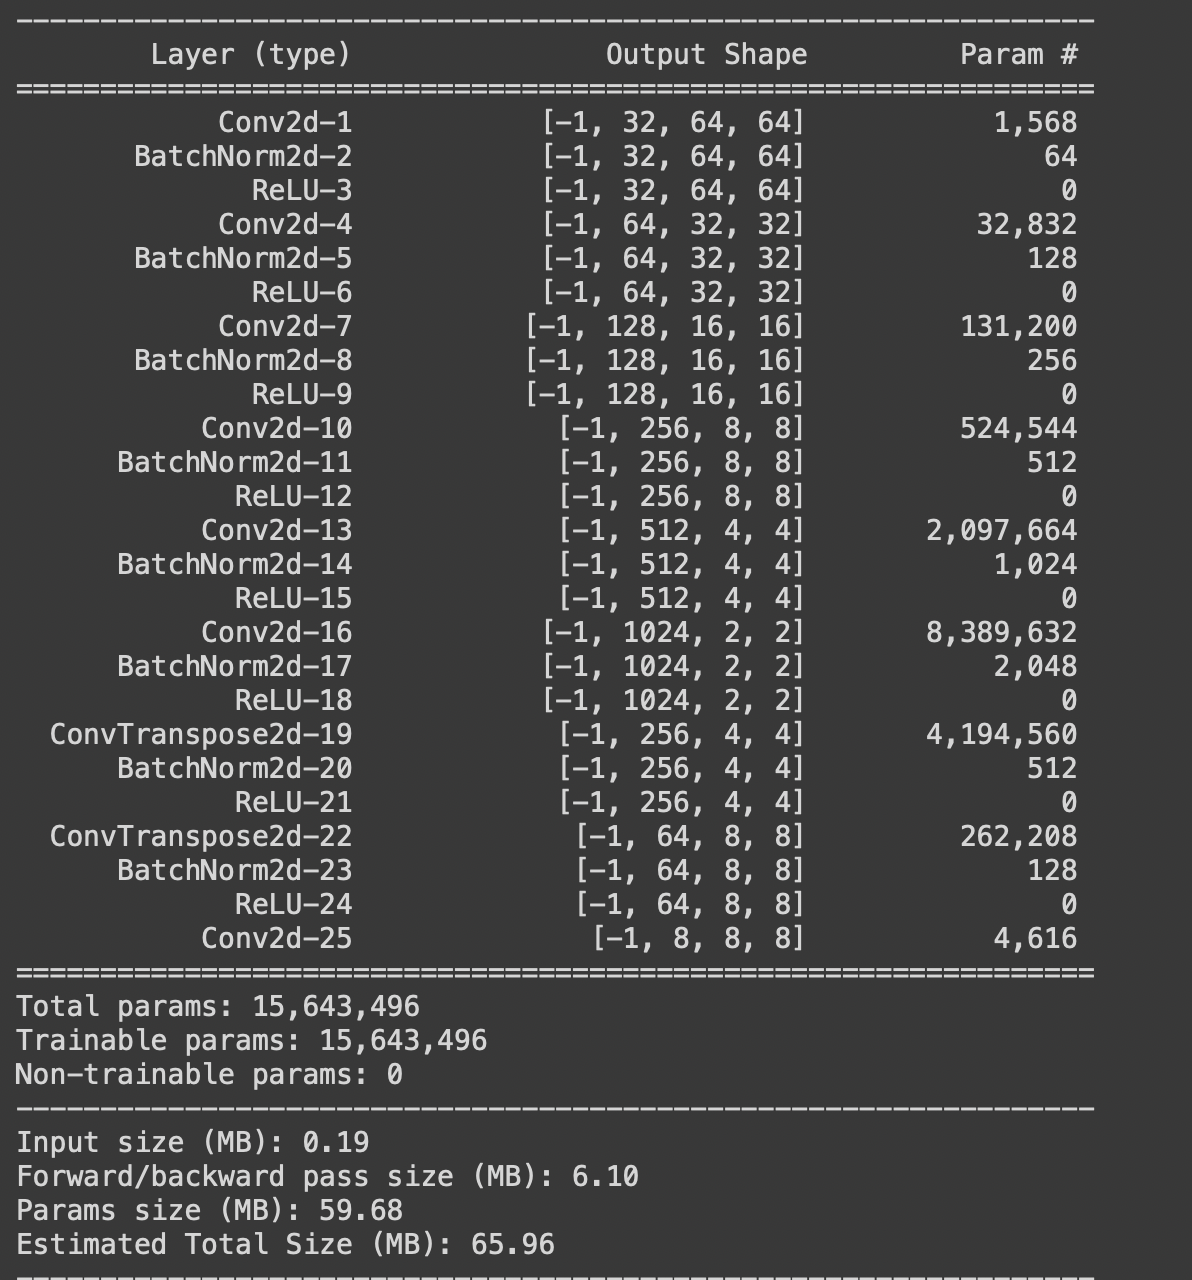

Each convolutional layer is followed by BatchNorm2d and ReLU activation. The final layer's output is passed through sigmoid activation which maps the output in range (0,1). The first convolutional layer takes input image of size 128 x 128 x 3. The output from last convolution layer is of size 8 x 8 x 8. During training, we have set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. All the convolutions conv1 to trans_conv8 uses stride=2 and padding=1 and the final convolutional layer conv9 is designed with stride=1 and padding=1.

During training we optimize the yolo_loss designed in previous section. It weights localization error equally with classification error which is not a desirable strategy. Additionally, numerous grid cells in each image lack any visible objects. As a result, those cells' "confidence" scores are pushed towards 0, frequently overwhelming the gradient from object-containing cells. This may result in model instability and early training divergence. To fix this, we lower the loss from confidence predictions for boxes without objects and raise the loss from bounding box coordinate predictions by using 2 hyperparameters as-$\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$. 

Both class probabilities and bounding box coordinates are predicted by our final layer. We adjust the bounding box dimensions to be between 0 and 1 by normalizing them by the dimensions of the image. The bounding box's x and y coordinates are parametrized to represent offsets of a certain grid cell location, ensuring that they are also constrained to the range of 0 and 1.

Each grid cell predicts B (=1 for this project) bounding boxes and confidence
scores for those boxes. The confidence Score expresses how certain we are that the box contains the object and how accurate we believe the box to be. The confidence score should be 0 if there is no object in the cell; otherwise, it should equal the IOU between the predicted box and the ground truth box.

For each grid cell, YOLO forecasts numerous bounding boxes. We only want one bounding box predictor to be in charge of each object. To elimiate these redundant boxes there are 2 techniques-
1. Get rid of predicted boxes with low objectness probability Pr  <0.6 (Implemented in this submission)
2. Non-Max suppression (Will be added in Part B)

#### Epochs and experiments performed

Initially, we started with 20 epochs and we observed that loss was starting to converge but the predictions were not that accurate as well as the loss was high. So, we decided to increase the epochs and train it further for better predictions. We trained the model for 80, 100 and 140 epochs for more analysis. For the submission we have submitted the model trained for 100 epochs with batch size 32. For this final model we have set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. 

Deviating from the original architechture we have used sigmoid as the final activation layer to map the predictions to the probablity space as the targets lie in 0-1 region as well. Later, we saw that in the original YOLO paper authors have used Leaky ReLU in their network architechture so aftere studying over it we tried to deviate and changed the original network architechture by adding Leaky ReLU after every convolution instead of ReLU. We have added the code below in the notebook. To decide what is better we still need to analyze the other metrics like precision, recall and mean average precision as looking at only loss plots is not sufficient to judge the performance. 

After working on Part B and completing the required code we will be better able to analyze the performance.

### 1.4

4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%) 

In [ ]:
# Setup your training
#Creating processed labels from law labels
processed_labels = np.asarray([process_labels([raw_labels[i]]) for i in range(len(raw_labels))])

#Creating the dataset
batch_size = 32
val_batch_size = 200

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(0.5,0.5)
     ]
)

class YOLODataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors, transform=None):
        # assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        if self.transform:
            x = self.transform(x)
        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        # print(self.tensors[0].shape[0])
        return self.tensors[0].shape[0]

# class YOLO

train_proportion = 0.85
train_idx = int(len(images) * train_proportion)
train_dataset = YOLODataset(tensors=(images[:], processed_labels[:]), transform = transform)
train_loader = DataLoader(train_dataset, batch_size = batch_size)
val_dataset = YOLODataset(tensors=(images[:train_idx], processed_labels[:train_idx]), transform = transform)
val_loader = DataLoader(val_dataset, batch_size = val_batch_size)

for image, label in train_loader:
  print(image.shape, label.shape,)
  break

model = YOLO().to(device)


torch.Size([32, 3, 128, 128]) torch.Size([32, 8, 8, 8])


In [ ]:
# Train your model
checkpoint_callback = pl_callbacks.ModelCheckpoint()
tb_logger = pl_loggers.TensorBoardLogger(save_dir = "logs")

trainer = pl.Trainer(gpus=1, logger=tb_logger, max_epochs=100, callbacks=[checkpoint_callback])
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name        | Type       | Params
-------------------------------------------
0 | conv1       | Sequential | 1.6 K 
1 | conv2       | Sequential | 33.0 K
2 | conv3       | Sequential | 131 K 
3 | conv4       | Sequential | 525 K 
4 | conv5       | Sequential | 2.1 M 
5 | conv6       | Sequential | 8.4 M 
6 | trans_conv7 | Sequential | 4.2 M 
7 | trans_conv8 | Sequential | 262 K 
8 | conv9       | Conv2d     | 4.6 K 
-------------------------------------------
15.6 M    Trainable params
0         Non-trainable params
15.6 M    Total par

Sanity Checking: 0it [00:00, ?it/s]

Val epoch: 0
[0.0, 0.0, 0.0] 0.0 Length: 3
MAP: 0.0


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 5
[0.0012771392081736908, 0.0006510416666666666, 0.0, 0.0006006006006006006, 0.001265022137887413, 0.0006485084306095979, 0.0005402485143165856, 0.0006195786864931846, 0.0, 0.0006049606775559588, 0.0, 0.0, 0.0016501650165016502, 0.0, 0.0006071645415907711, 0.0, 0.0, 0.0006049606775559588, 0.0005574136008918618, 0.0018484288354898336, 0.0018552875695732839, 0.0011737089201877935, 0.0, 0.0012012012012012011, 0.0006472491909385113, 0.0012674271229404308, 0.0, 0.0018382352941176473, 0.0011883541295306, 0.0011554015020219526, 0.0011574074074074073, 0.0018484288354898336, 0.0, 0.0006337135614702154, 0.0011634671320535194, 0.0, 0.0006172839506172839, 0.0017543859649122807, 0.0, 0.0017953321364452424, 0.0012012012012012011, 0.0005767012687427913, 0.0] 0.032550018983184964 Length: 43
MAP: 0.0007569771856554642


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 10
[0.013428754068613822, 0.017578373548428932, 0.00786352125448379, 0.01226266926266926, 0.017995603943032706, 0.016888679506640955, 0.011131409369914873, 0.013513182687512565, 0.011837622566367507, 0.011650612421234932, 0.015319127483367346, 0.020435742457461412, 0.010569160733308727, 0.013510054322242572, 0.01507227774475845, 0.017878486066784726, 0.016203340816053655, 0.015322868096700278, 0.0116288634312608, 0.011325382384411558, 0.013445265996286405, 0.013119621921038488, 0.012215974944591472, 0.014845020590634627, 0.010231716276683062, 0.018595433757950624, 0.011432816565044267, 0.021286777135828713, 0.01402344522708688, 0.017293909420394857, 0.014857994871673212, 0.022699345772124877, 0.01556374995673953, 0.014547859150272771, 0.009212544291078324, 0.012070168240184838, 0.007530580566642944, 0.017268942682726274, 0.013797774552491532, 0.011640547762630349, 0.013102772778113753, 0.015523332530655838, 0.016260162601626018] 0.6119814897577486 Length: 43
MAP: 0.014232127

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 15
[0.037267038488440866, 0.0466660386684801, 0.029904831573697856, 0.03589182659545132, 0.03657107639078422, 0.0262127798120016, 0.03033046189219135, 0.03275639190434104, 0.0274526486319935, 0.03989260759853016, 0.038236457487871564, 0.038674242424242423, 0.033538150080336906, 0.029742330664988496, 0.03850788329878544, 0.040202009936258, 0.030106542751707963, 0.03386064056930315, 0.02361740581167657, 0.02799195741328302, 0.03366988194792395, 0.03501734874128665, 0.038697143116247126, 0.0390059930337595, 0.026362079022897392, 0.037610454591339604, 0.023639630825229744, 0.033784649158062605, 0.029747615325314822, 0.04073245765831269, 0.04628934303102853, 0.04414853024582824, 0.034147792307850616, 0.03158816255177766, 0.036953009594478885, 0.03242159499219669, 0.03100084832987568, 0.04191367426283443, 0.04412302819949967, 0.028596679823186186, 0.032566129911210474, 0.03851144840865989, 0.032520325203252036] 1.4904711422764187 Length: 43
MAP: 0.03466211958782369


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 20
[0.05450014771732242, 0.05793847732813947, 0.03644636680201359, 0.04513069882174143, 0.049836505569576695, 0.04173467779569911, 0.040103754763098645, 0.04409194897844352, 0.04057777757856852, 0.051348774028930594, 0.05549538448577524, 0.04939741672499299, 0.0404980606099744, 0.04068494560771657, 0.05300324129056321, 0.049630949457311925, 0.03747333843373455, 0.04806256258658589, 0.0485623012227378, 0.04335340913924026, 0.04750607602071707, 0.05089093482759959, 0.04704664881147733, 0.057738536031239705, 0.04963611747704763, 0.04929644491547907, 0.03532276411362394, 0.06032207640869628, 0.03652888595102372, 0.04789460236567974, 0.04696150677904829, 0.060200678220689086, 0.050936632654138815, 0.04783029475772637, 0.05416840016107608, 0.04844007807446194, 0.03939294941673747, 0.06065203892336596, 0.04502667676516817, 0.039483475083597765, 0.05487920408266305, 0.04386602171322874, 0.05813008130081301] 2.0600218637974663 Length: 43
MAP: 0.04790748520459224


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 25
[0.11667083152961787, 0.10939765672114778, 0.1024061264000452, 0.11496758646739232, 0.09071995372205115, 0.09155988544272924, 0.09483574421353207, 0.09761671636377972, 0.10340038672413503, 0.095509478303492, 0.11400376980373468, 0.12387011870002936, 0.09914363843107687, 0.0845673125401405, 0.09974515472814836, 0.10639298701009242, 0.09020651094011913, 0.10435612181291502, 0.09886664609598962, 0.0930125866733449, 0.09770922370694805, 0.10625070591296709, 0.10507120474856162, 0.11312913983904856, 0.10120098416514763, 0.11556134863034834, 0.08216296394161098, 0.09938233348979823, 0.10300662885231278, 0.10453910588127661, 0.1028439303737581, 0.11751773629667968, 0.11908104700467899, 0.09618172571037993, 0.11128813002986455, 0.11458512781729252, 0.0966553228001008, 0.11043920029473737, 0.10260285010569675, 0.09189827135999146, 0.1183016647155759, 0.11737717507952332, 0.1132462839779913] 4.471281317357803 Length: 43
MAP: 0.10398328645018147


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 30
[0.13200681512797657, 0.1361336775883842, 0.10446642408809137, 0.12103199984444872, 0.11003432828762542, 0.10503444949916801, 0.11047837186443371, 0.10388442250359471, 0.1067404974130911, 0.1033002838869241, 0.09980840215116611, 0.1161517675186875, 0.12553173680125704, 0.10715960289964328, 0.10808515311009069, 0.1169741614252681, 0.09247763192862019, 0.10565980533606222, 0.09684570202618359, 0.10497057470063297, 0.10301961638858183, 0.11283650635494967, 0.11132719430090356, 0.11312768807461261, 0.10584035184091985, 0.10199682517821046, 0.10318857377621972, 0.11813788311790187, 0.10672794247708471, 0.1253083459351282, 0.11362598799780572, 0.12138834213080639, 0.1158184406683983, 0.11880844048373718, 0.12951206511564803, 0.14715700459109812, 0.1039377117784054, 0.11072996499428762, 0.11192069329430115, 0.10173636307308027, 0.12328116948384855, 0.11175189113737845, 0.08011517615176152] 4.798069986346418 Length: 43
MAP: 0.11158302293828878


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 35
[0.1685886428627663, 0.1627594194085598, 0.13754044258430156, 0.1288820864810916, 0.12751725334319022, 0.12268143681916965, 0.13402730484342865, 0.12613450686834707, 0.13531167256942003, 0.1257057782203743, 0.13329687892502703, 0.13321884953269977, 0.13954944576156192, 0.11578224378937839, 0.13599523197860477, 0.1364823407862299, 0.10609955393660479, 0.12772198427130668, 0.1144357340689713, 0.11955030425956081, 0.11071205366962007, 0.13435486444557507, 0.12862166521456672, 0.13051419400174816, 0.12202398125002935, 0.11920424094406452, 0.09994385467980745, 0.1494776923138114, 0.11565900582618964, 0.14412578923849784, 0.1234053674382772, 0.1529220139256827, 0.13040778256349214, 0.12082437779646944, 0.13305138445261822, 0.16057618400942295, 0.12739664982296528, 0.12217838901204854, 0.1375032741670581, 0.12581218023218052, 0.14942923380086134, 0.15372998607412616, 0.10331978319783199] 5.62647505938754 Length: 43
MAP: 0.13084825719505908


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 40
[0.21990100348152444, 0.22625212818002308, 0.18502238586604358, 0.17787293843468047, 0.16407104787706675, 0.1826012008017405, 0.1645850977733843, 0.16984364048417558, 0.18288524618968527, 0.1648141420762656, 0.15444839358880186, 0.17261480927501396, 0.18773542554207492, 0.16047534081500378, 0.16325769254401754, 0.1899051687683155, 0.1368767909748704, 0.16212266929841168, 0.15687548949627392, 0.1434057628694581, 0.14026260914704855, 0.1876825354711967, 0.16117179784793453, 0.16674105441937628, 0.15853465117777618, 0.17370963280169768, 0.1396637884277029, 0.18913351880256182, 0.19346351795964525, 0.17483199743098662, 0.15847060296255186, 0.18227871139126853, 0.18420233622852003, 0.15989291574542072, 0.1616543852443674, 0.2039887289505172, 0.18541328940044124, 0.15977865380533296, 0.15722673633135423, 0.14448808253567538, 0.1704080641749733, 0.17935851605363776, 0.19139566395663957] 7.389318164603459 Length: 43
MAP: 0.1718446084791502


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 45
[0.14602570948860896, 0.1475463722621865, 0.1109251675839276, 0.13104407890017586, 0.1121151046480356, 0.12750290332369332, 0.11444144078730312, 0.10293966771686185, 0.12272661417370868, 0.10767065371102352, 0.10299602598859364, 0.1258932970739465, 0.13156242815070854, 0.10963253300778701, 0.1126960220813402, 0.12593103577335427, 0.10139054957707809, 0.10318660334700604, 0.11436915945630638, 0.11822273260659406, 0.10347871968376944, 0.11652374226802868, 0.11556953045857438, 0.11894473917686792, 0.11209368519332431, 0.11089219661236027, 0.08806586101547087, 0.12321630629386975, 0.11243179497905974, 0.13158776111477002, 0.1202286806515499, 0.1266621040007395, 0.11309923667802957, 0.1155177493960764, 0.11594224387121206, 0.13414521769876617, 0.1188566116314498, 0.11997699304899001, 0.1258168129309313, 0.08931333812179328, 0.12833900609568144, 0.143744064748623, 0.08705962059620596] 5.040324115924383 Length: 43
MAP: 0.11721683990521821


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 50
[0.31370535631090385, 0.2939256082978052, 0.2994049227255643, 0.29196976230704363, 0.2694450344178802, 0.23054436064682618, 0.25633688325307985, 0.26067758076984976, 0.28334879837941984, 0.2521618056758588, 0.2540913703196233, 0.2874843968843411, 0.30060751175842504, 0.2438000964771466, 0.2805842248581522, 0.2705685689948761, 0.231583755034892, 0.2595511884834911, 0.2545058925033945, 0.23076210806013694, 0.22363394183226692, 0.2526346033633155, 0.23439739655406677, 0.28227231619105186, 0.24341292016404134, 0.25631247266836804, 0.2254393151693991, 0.269879084446534, 0.2585294620153238, 0.265359621414135, 0.2762400189146628, 0.26270149632347145, 0.25279015112670783, 0.2725658699522162, 0.2522359469748862, 0.28427832571221656, 0.27648946580542916, 0.287159852634908, 0.2914051784923457, 0.24769532421185747, 0.27986783436522616, 0.2819371460824643, 0.23515004372011683] 11.37744701429372 Length: 43
MAP: 0.2645917910300865


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 55
[0.2674785581752273, 0.26537838125156143, 0.26568615857989836, 0.2617145133967302, 0.20416018986342024, 0.2571993481055885, 0.23635398091845902, 0.23433220822270603, 0.22744867569253588, 0.240036574509467, 0.23732221972476167, 0.2513225880772069, 0.2541817046712547, 0.23199637714439172, 0.24974924777139465, 0.24783337987093654, 0.20247942974749134, 0.23120102225741027, 0.21639484833204767, 0.21044035668359937, 0.2170595480291191, 0.25295754590804514, 0.2242936028158553, 0.22885755209553207, 0.24555134183123017, 0.25982165833601584, 0.1936086837179745, 0.24843554635710277, 0.2764064975047408, 0.2574223138738125, 0.2296901347570458, 0.228067813318525, 0.2491318307389998, 0.22525559010186003, 0.22007476084860533, 0.2567636475695145, 0.25556057839458957, 0.24679041966681314, 0.24882063156074793, 0.24361682576837665, 0.26586306484323746, 0.2583199541100008, 0.23152987482255774] 10.356609179966389 Length: 43
MAP: 0.24085137627828812


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 60
[0.3883701184168011, 0.37822484404257534, 0.37030700117208504, 0.35754508779655575, 0.3336421806216158, 0.3562187364408622, 0.336494113282413, 0.3479810968947416, 0.389788803552966, 0.34379926826355683, 0.3131575359895463, 0.3421641425952902, 0.38252179444952433, 0.32765738627457136, 0.33146685049474534, 0.3450523991439498, 0.28946633508501834, 0.3343847623400506, 0.32771574786272534, 0.317161810974625, 0.3207982159405399, 0.32908582166315764, 0.330553124409027, 0.3328999459346393, 0.34081944037992895, 0.34610531223438307, 0.286964455147824, 0.3553691218513128, 0.35420068519311787, 0.3318494702037753, 0.3307760996872769, 0.34173519940519465, 0.33692766739346824, 0.33917590900658895, 0.3158051984769632, 0.3791991520168889, 0.35925575454511477, 0.3291627877733897, 0.35551292843975935, 0.3519007763683075, 0.36343504233186463, 0.35922066907970046, 0.3126398898562337] 14.716512683032681 Length: 43
MAP: 0.34224448100076005


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 65
[0.32528907993240036, 0.3196261729870649, 0.30852497496510306, 0.3147796463209422, 0.27381535906891014, 0.2711339838819236, 0.2928020123882599, 0.29747248938809, 0.3137439008483696, 0.28039458219001084, 0.2585479031682258, 0.32453848422145765, 0.31794836547252653, 0.270939229621967, 0.2910964701316581, 0.31016466569641316, 0.2709300695545222, 0.2824883120731911, 0.25578379272491625, 0.30065409516386393, 0.2792176737901427, 0.2832894503722166, 0.2841930101897031, 0.2967041669476685, 0.3117200241565095, 0.31693370120323844, 0.26967979784492896, 0.32097516594335657, 0.3499835175097248, 0.29402698746066375, 0.2917288943112012, 0.2994609157363087, 0.3081610102557108, 0.2827957551160103, 0.2739641053526302, 0.3527827082600756, 0.32167151343208794, 0.2850787066941177, 0.3028807133565487, 0.3049996382240349, 0.3180850803395651, 0.33840772795669416, 0.30428202857064646] 12.8716958828236 Length: 43
MAP: 0.2993417647168279


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 70
[0.3885205520037392, 0.3623327841660325, 0.3678562087636366, 0.370421910960598, 0.3117778182554604, 0.3445000410232358, 0.34496096543693394, 0.3460107475892105, 0.3764416347842508, 0.344604862227083, 0.30614480136294697, 0.34540235137426706, 0.372793874294961, 0.3343128281761643, 0.32749976768396155, 0.37067190036915004, 0.3408165575965482, 0.35001243865815806, 0.29874044224551716, 0.3245181731258735, 0.3462679206589325, 0.35828875005419203, 0.3143127948896762, 0.3501302657136443, 0.3691857647011623, 0.3746985604904894, 0.3133362139602198, 0.3689475649328164, 0.3917467746949777, 0.33804323372011313, 0.3503569064034802, 0.3519882178839982, 0.3751995720644628, 0.3589017571867769, 0.3285984905440155, 0.37939799365940585, 0.37228828335465175, 0.35495860925590605, 0.3637572296814393, 0.35332019282769506, 0.37166447991418045, 0.3653075747081935, 0.3514327531095824] 15.130470564507739 Length: 43
MAP: 0.35187140847692416


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 75
[0.32419405193757916, 0.3088925520815072, 0.28945038395124967, 0.30321399955508005, 0.2601658743124135, 0.27392992799859944, 0.2475963851271258, 0.27061172417484697, 0.2890990421570727, 0.29187559620161174, 0.2677014171462219, 0.2672509475031831, 0.2978783311336814, 0.2789577783340395, 0.28912411962567175, 0.2834215377119873, 0.27583485770120264, 0.28725905789110245, 0.27528526264043185, 0.2668714951649304, 0.2772908129328338, 0.3024875370762283, 0.2566099167276031, 0.2650889881598639, 0.2771103923342018, 0.31343561302100387, 0.2572282837248566, 0.2953884354536847, 0.30292069295682983, 0.29269722134683235, 0.2757485355882558, 0.2586894477595078, 0.2722522498491804, 0.26821093922887945, 0.2679729134167252, 0.30651147460356487, 0.2809876406157949, 0.25942366695133384, 0.2966968119273327, 0.24237466284398348, 0.3007798103076807, 0.31011472155671166, 0.2796155149051491] 12.10825062563758 Length: 43
MAP: 0.28158722385203677


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 80
[0.27515518670877853, 0.2948759715015053, 0.2863835598694783, 0.29974319302548874, 0.22161814425488902, 0.22755976257490948, 0.2849900363017763, 0.29872781000977056, 0.2909974489236891, 0.24881924627345553, 0.24297530423627667, 0.2929275003642474, 0.315377173261255, 0.24039270780761937, 0.281661705813035, 0.30574280820508054, 0.2757522656193871, 0.24144049158043104, 0.23233388154856796, 0.2948824504757335, 0.2928608358359142, 0.2544928616613694, 0.19989735878667617, 0.2564316086712421, 0.30055659467233525, 0.28777823279107057, 0.18718220272682143, 0.21112762966944895, 0.3260609265425869, 0.29773076136265897, 0.2499869418147452, 0.2382598706155639, 0.28848691566779583, 0.2719513701306209, 0.1953463330028503, 0.23211252458603285, 0.27140578599176984, 0.2618830951673691, 0.2468187401474368, 0.2324683708532592, 0.28587458817573125, 0.29825631606535985, 0.26810701625234146] 11.407433529546376 Length: 43
MAP: 0.2652891518499157


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 85
[0.44888168833511893, 0.42615966862568405, 0.40379531051496304, 0.4207391053270228, 0.4098281695488591, 0.40330994266340053, 0.40058343415865316, 0.41384582559030975, 0.4354847176811037, 0.41943729300208893, 0.38764360756299854, 0.4166304859675017, 0.44388468484231364, 0.39262359849972456, 0.4157248074209285, 0.41065565932160547, 0.39855782075995544, 0.41648450200032644, 0.3844078244932032, 0.38568189387878626, 0.39287250784943556, 0.4000109527585038, 0.40937571383009724, 0.4207448034563968, 0.4301100764287929, 0.42583913131361834, 0.3379145228992492, 0.41384077357371485, 0.4190504541841793, 0.3938431762738855, 0.42864577425839023, 0.39944713632165835, 0.39870201470650385, 0.4272387801304598, 0.38522756492863025, 0.4554060210583917, 0.4471758498848178, 0.4066743192972074, 0.41221148422750314, 0.42078734431627635, 0.43272707380884645, 0.4088531387976598, 0.32809797262717905] 17.629156627125948 Length: 43
MAP: 0.4099803866773476


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 90
[0.40429853990476583, 0.3881696165186996, 0.3926857648062844, 0.3755270983499342, 0.3472596636838395, 0.39382285183266824, 0.37061335394316625, 0.37174986537475024, 0.38702763625714137, 0.3784459526348571, 0.37440171329267696, 0.36688346423245616, 0.40594110935304756, 0.38836235332193597, 0.3821122088182581, 0.3947065899422955, 0.3613173686781857, 0.4059769949899376, 0.3651783697223474, 0.3734756741261896, 0.37239244621269596, 0.40778791926401153, 0.3647154234813356, 0.3842200549853678, 0.3883878166748708, 0.3957927634862674, 0.31907214070662865, 0.39192389685298173, 0.4117061904973836, 0.37797515171069324, 0.38065351659551155, 0.35282549764489524, 0.3791006455585147, 0.3902961481931386, 0.359807249662159, 0.4137570559543497, 0.37854072825240254, 0.37513131561573454, 0.38491008056397275, 0.35134273362290963, 0.40403976145927106, 0.3957415064879129, 0.3489805136146599] 16.357056746881106 Length: 43
MAP: 0.38039666853211873


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 95
[0.2032144621725415, 0.1802089692968852, 0.17594369792875966, 0.17485853997678658, 0.16207977078378893, 0.16207923032950713, 0.17694068884345246, 0.16947604041822392, 0.1375996051575962, 0.1564495013344184, 0.1804469441859732, 0.19336808953241705, 0.19260719749833544, 0.17500281614767668, 0.19231865420984348, 0.2132861546253252, 0.14992668457596134, 0.18639905574527071, 0.1768254252299698, 0.16045335779429815, 0.19171842460356006, 0.20504015507946596, 0.18876838459711046, 0.15437129479984002, 0.175551643967885, 0.2178824068396805, 0.16866483401424118, 0.16070832745868424, 0.21658355071788235, 0.21251407770770991, 0.18792056511648725, 0.16465948281231743, 0.18185009180130676, 0.17272306553012937, 0.18869757935908751, 0.20581427227634555, 0.16118290898623353, 0.14738332573265558, 0.19236148453524474, 0.15453032370439715, 0.18285693697913588, 0.20129876525760002, 0.19875466496134017] 7.751321452625371 Length: 43
MAP: 0.18026328959593885


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Val epoch: 100
[0.34419701263347474, 0.2948464135696119, 0.29824030193150564, 0.33300881689892875, 0.2782397709165118, 0.2860859182428233, 0.2874105031145915, 0.30078661108929033, 0.32746872285585976, 0.3192618287647477, 0.2897237744294161, 0.31803236090508397, 0.3253829034267128, 0.2967075390922861, 0.31590321940324856, 0.3262023877301441, 0.282688110607255, 0.3078837845348515, 0.2960881891059887, 0.29465570658802787, 0.2964808606109905, 0.3221968010625859, 0.2874106766787634, 0.30187554557962, 0.31846487835940535, 0.32465718197807214, 0.2814124990751967, 0.32075697649558016, 0.3373674116574526, 0.29857038126472385, 0.3022957435870808, 0.307828174543526, 0.31176924699764025, 0.2926785078128823, 0.26674679173914556, 0.29428590599471705, 0.31127912313947587, 0.2908748696617489, 0.3130619608178371, 0.28697224959038886, 0.27853911304969453, 0.31324033945696755, 0.2626291413605836] 13.044208256354441 Length: 43
MAP: 0.30335368038033583


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


### Plotting Loss

31000



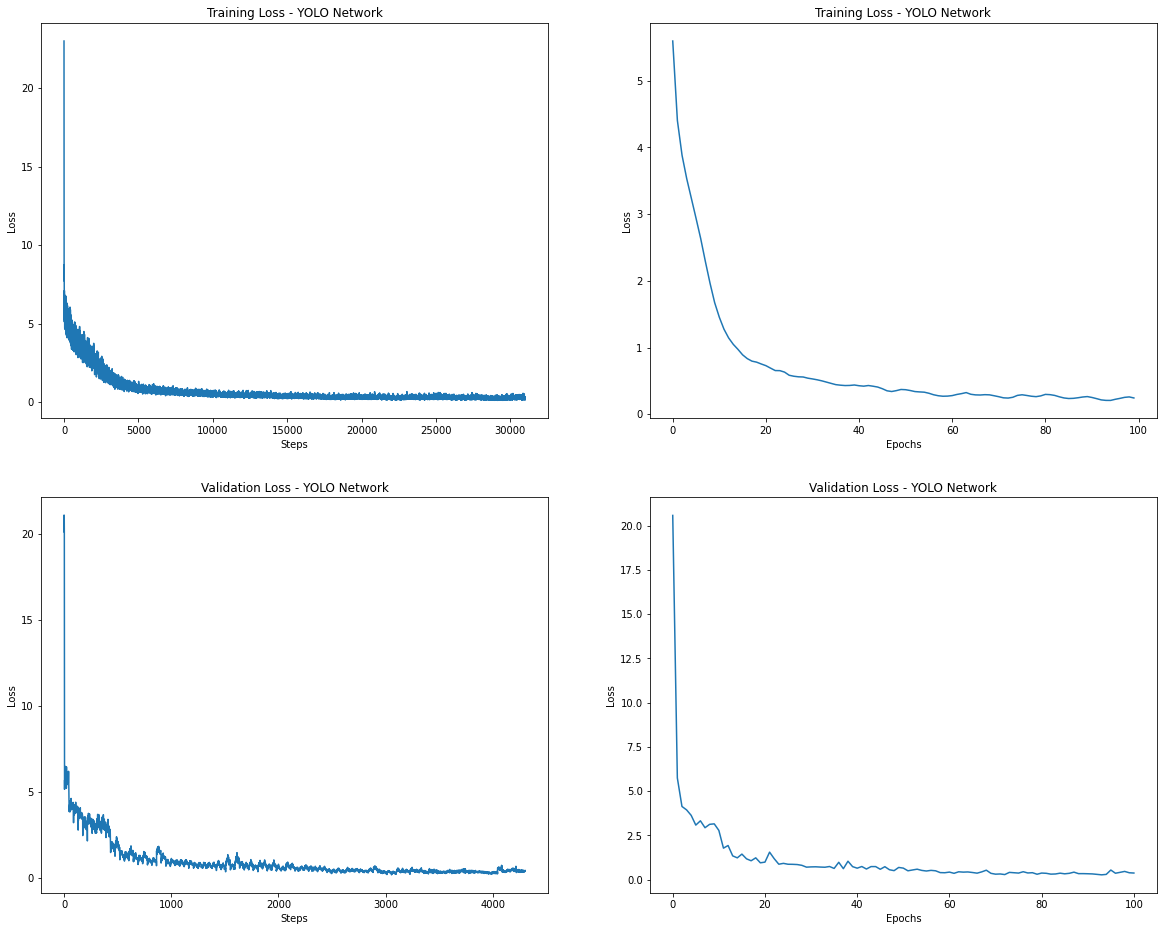

In [ ]:
f, axarr = plt.subplots(2,2, figsize = (20,16))
print(len(model.training_losses))
# plt.figure(figsize = (10,8))
axarr[0,0].plot(model.training_losses)
axarr[0,0].set_title("Training Loss - YOLO Network")
axarr[0,0].set_xlabel("Steps")
axarr[0,0].set_ylabel("Loss")


axarr[0,1].plot(model.train_losses_epoch)
axarr[0,1].set_xlabel("Epochs")
axarr[0,1].set_ylabel("Loss")
axarr[0,1].set_title("Training Loss - YOLO Network")
print()
axarr[1,0].plot(model.val_losses)
axarr[1,0].set_title("Validation Loss - YOLO Network")
axarr[1,0].set_xlabel("Steps")
axarr[1,0].set_ylabel("Loss")


axarr[1,1].plot(model.val_losses_epoch)
axarr[1,1].set_xlabel("Epochs")
axarr[1,1].set_ylabel("Loss")
axarr[1,1].set_title("Validation Loss - YOLO Network")
plt.show()

In [ ]:
# %load_ext tensorboard
# # %reload_ext tensorboard
# %tensorboard --logdir logs

In [ ]:
# trainer.save_checkpoint("/content/drive/MyDrive/Colab Notebooks/CIS 6800/HW2/YOLO_300epch.ckpt")
# new_model = YOLO.load_from_checkpoint(checkpoint_path="/content/drive/MyDrive/Colab Notebooks/CIS 6800/HW2/YOLO_80epch.ckpt")

## Deviation- Using LeakyReLU instead of ReLU Activation Function

In [ ]:
# import torch.nn.functional as F

# class YOLO(pl.LightningModule):
#     def __init__(self):
#       super().__init__()
#       self.conv1 = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=4, stride = 2, padding = 1),
#             nn.BatchNorm2d(32),
#             nn.LeakyReLU(0.1))
#       self.conv2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=4, stride = 2, padding = 1),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.1))
#       self.conv3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=4, stride = 2, padding = 1),
#             nn.BatchNorm2d(128),
#             nn.LeakyReLU(0.1))
#       self.conv4 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=4, stride = 2, padding = 1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.1))
#       self.conv5 = nn.Sequential(
#             nn.Conv2d(256, 512, kernel_size=4, stride = 2, padding = 1),
#             nn.BatchNorm2d(512),
#             nn.LeakyReLU(0.1))
#       self.conv6 = nn.Sequential(
#             nn.Conv2d(512, 1024, kernel_size=4, stride = 2, padding = 1),
#             nn.BatchNorm2d(1024),
#             nn.LeakyReLU(0.1))
#       self.trans_conv7 = nn.Sequential(
#             nn.ConvTranspose2d(1024, 256, kernel_size=4, stride = 2, padding = 1),
#             nn.BatchNorm2d(256),
#             nn.LeakyReLU(0.1))
#       self.trans_conv8 = nn.Sequential(
#             nn.ConvTranspose2d(256, 64, kernel_size=4, stride = 2, padding = 1),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(0.1))
#       self.conv9 = nn.Conv2d(64, 8, kernel_size=3, stride = 1, padding = 1)

#       self.training_losses = []
#       self.val_losses = []
#       self.val_losses_epoch = []
#       self.train_losses_epoch = []

#     def forward(self, x):
#       x = self.conv1(x)
#       x = self.conv2(x)
#       x = self.conv3(x)
#       x = self.conv4(x)
#       x = self.conv5(x)
#       x = self.conv6(x)
#       x = self.trans_conv7(x)
#       x = self.trans_conv8(x)
#       x = self.conv9(x)
#       # x = F.log_softmax(x, dim=1)
#       x = torch.sigmoid(x)
#       return x

#     def calculate_iou(self, output, target):
      
#       grid_size = 16
#       image_size = 128
#       #Taking dimension in pixel space instead of grid space
#       op_x1, op_x2 = ((output[:,:,:,1] * grid_size) - (0.5*output[:,:,:,3]*image_size) ), ((output[:,:,:,1] * grid_size) + (0.5*output[:,:,:,3]*image_size))
#       trg_x1, trg_x2 = ((target[:,:,:,1] * grid_size) - (0.5*target[:,:,:,3]*image_size)), ((target[:,:,:,1] * grid_size) + (0.5*target[:,:,:,3]*image_size))
#       op_y1, op_y2 = ((output[:,:,:,2] * grid_size) - (0.5*output[:,:,:,4]*image_size)), ((output[:,:,:,2] * grid_size) + (0.5*output[:,:,:,4]*image_size))
#       trg_y1, trg_y2 = ((target[:,:,:,2] * grid_size) - (0.5*target[:,:,:,4]*image_size)), ((target[:,:,:,2] * grid_size) + (0.5*target[:,:,:,4]*image_size))

#       # min(op_x2,trg_x2) - max(op_x1,trg_x1)
#       intersect_width = torch.minimum(op_x2,trg_x2) - torch.maximum(op_x1, trg_x1)
#       # min(op_y2,trg_y2) - max(op_y1,trg_x2)
#       intersect_height = torch.minimum(op_y2,trg_y2) - torch.maximum(op_y1, trg_y1)

#       intersection = torch.clamp(intersect_width,0) * torch.clamp(intersect_height,0)
#       union = torch.clamp(((output[:,:,:,3] * image_size * output[:,:,:,4] * image_size) + (target[:,:,:,3] * image_size * target[:,:,:,4] * image_size) - intersection),1e-6)
#       IOU = intersection/union
#       return IOU

#     def yolo_loss(self, output, target):
#       lambda_noobj = 0.5
#       lambda_coord = 5
#       output, target = torch.permute(output,(0,3,2,1)), torch.permute(target, (0,3,2,1))
#       batch_size = output.shape[0]
#       obj_mask = target[:,:,:,0] 
#       neg_obj_mask = 1 - obj_mask
#       coord_loss = lambda_coord * torch.sum(obj_mask * (torch.square(output[:,:,:,1] - target[:,:,:,1]) + torch.square(output[:,:,:,2] - target[:,:,:,2])))
#       dimension_loss = lambda_coord * torch.sum(obj_mask * (torch.square(output[:,:,:,3]**0.5 - target[:,:,:,3]**0.5) + torch.square(output[:,:,:,4]**0.5 - target[:,:,:,4]**0.5)))

#       IOU = self.calculate_iou(output, target)
#       box_confidence_pred = output[:,:,:,0] 
#       box_confidence_trg = target[:,:,:,0] 

#       obj_box_confidence_loss = torch.sum(obj_mask * torch.square(box_confidence_pred - (box_confidence_trg * IOU)))
#       no_obj_box_confidence_loss = lambda_noobj * (torch.sum(neg_obj_mask * torch.square(box_confidence_pred - (box_confidence_trg * IOU))))                     
#       pred_class_loss = torch.sum(obj_mask * torch.sum(torch.square(output[:,:,:,-3:] - target[:,:,:,-3:]), -1))
      
#       loss = (coord_loss + dimension_loss + obj_box_confidence_loss + no_obj_box_confidence_loss + pred_class_loss)/batch_size
#       # print(loss)
#       return loss

#     def training_step(self, batch, batch_idx):
#         x, y = batch
#         y_pred = self(x)
#         train_loss = self.yolo_loss(y_pred, y)
#         # logs metrics for each training_step,and the average across the epoch, to the progress bar and logger
#         self.log("train_loss", train_loss, prog_bar = True, logger=True)#, on_step=True, on_epoch=True, prog_bar=True, logger=True)
#         self.training_losses.append(train_loss.item())
#         return train_loss

#     def validation_step(self, batch, batch_idx):
#         x, y = batch
#         y_pred = self(x)
#         val_loss = self.yolo_loss(y_pred, y)
#         self.log("val_loss", val_loss, prog_bar = True, logger=True)#on_step=True, on_epoch=True, prog_bar=True, logger=True)
#         self.val_losses.append(val_loss.item())
#         return val_loss

#     def training_epoch_end(self, outputs):
#       if outputs:
#         self.train_losses_epoch.append(torch.tensor([x['loss'] for x in outputs]).mean().item())

#     def validation_epoch_end(self, outputs):
#       if outputs:
#         self.val_losses_epoch.append(torch.tensor(outputs).mean().item())

#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=10e-3)
#         return optimizer

# model = YOLO().to(device)

In [ ]:
# # Train your model
# checkpoint_callback = pl_callbacks.ModelCheckpoint()
# tb_logger = pl_loggers.TensorBoardLogger(save_dir = "logs")

# trainer = pl.Trainer(gpus=1, logger=tb_logger, max_epochs=100, callbacks=[checkpoint_callback])
# trainer.fit(model, train_loader, val_loader)

In [ ]:
# f, axarr = plt.subplots(2,2, figsize = (20,16))
# print(len(model.training_losses))
# # plt.figure(figsize = (10,8))
# axarr[0,0].plot(model.training_losses)
# axarr[0,0].set_title("Training Loss - YOLO Network")
# axarr[0,0].set_xlabel("Steps")
# axarr[0,0].set_ylabel("Loss")


# axarr[0,1].plot(model.train_losses_epoch)
# axarr[0,1].set_xlabel("Epochs")
# axarr[0,1].set_ylabel("Loss")
# axarr[0,1].set_title("Training Loss - YOLO Network")
# print()
# axarr[1,0].plot(model.val_losses)
# axarr[1,0].set_title("Validation Loss - YOLO Network")
# axarr[1,0].set_xlabel("Steps")
# axarr[1,0].set_ylabel("Loss")


# axarr[1,1].plot(model.val_losses_epoch)
# axarr[1,1].set_xlabel("Epochs")
# axarr[1,1].set_ylabel("Loss")
# axarr[1,1].set_title("Validation Loss - YOLO Network")
# plt.show()

#PART 2.b

### Loading model from checkpoint

In [ ]:
new_model = YOLO.load_from_checkpoint(checkpoint_path="/content/drive/MyDrive/Colab Notebooks/CIS 6800/HW2/YOLO_140epch.ckpt")

## Visualizing random outputs of trained model

### Helper Function: Converting tensor to image:

In [ ]:
def convert_tensor_to_image(image):
  image = torch.permute(image, (1,2,0))
  image = image + 1
  image = torch.div(image,2) * 255
  image = np.array(image, dtype=np.uint8)
  return image

For Part B we started by loading the trained model from partA and using the same parameters as mentioned in above section.

Learning Rate- 10e-3
Optimizer- Adam
ReLU Activation Function 

The network architecture is shown in Section3

From the above images we can observe that model used to predict a lot of redundant bounding boxes. We used non-max suppression and low-confidence suppression to get rid of those boxes. First we got rid of  predicted boxes with low objectness probability (Pr $<$ 0.6) and then used non-max suppression. For NMS we  calculated the IoU for each class for all the bounding boxes and cluster boxes with IoU > 0.5 as a group, then for each group, we found the one with highest Pr and suppressed the other boxes. 

### 1.5
**Show a plot of the mean Average Precision over training for your model. (10%)**

The plot visualizes the mAP value observed over training of model

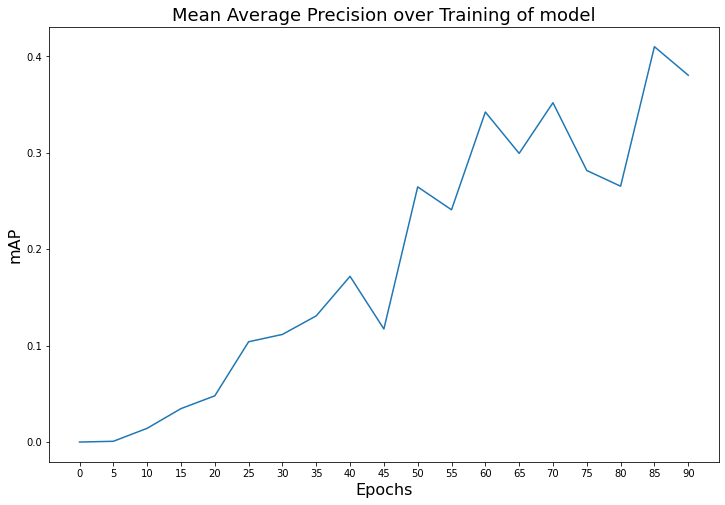

In [ ]:
plt.figure(figsize = (12,8))
plt.plot(model.map_epoch[:19])
plt.xticks(ticks = [i for i in range(len(model.map_epoch[:19]))],labels = [i*5 for i in range(len(model.map_epoch[:19]))])
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("mAP", fontsize=16)
plt.title("Mean Average Precision over Training of model", fontsize=18)
plt.savefig("/content/drive/MyDrive/Colab Notebooks/CIS 6800/HW2/mAP_Curve")
plt.show()

### 1.6
**For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)**

Original ground truth:


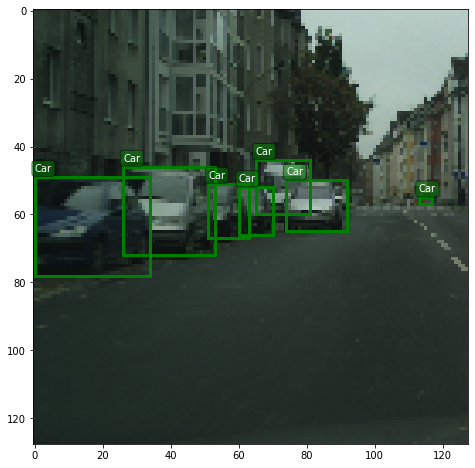

Raw prediction:


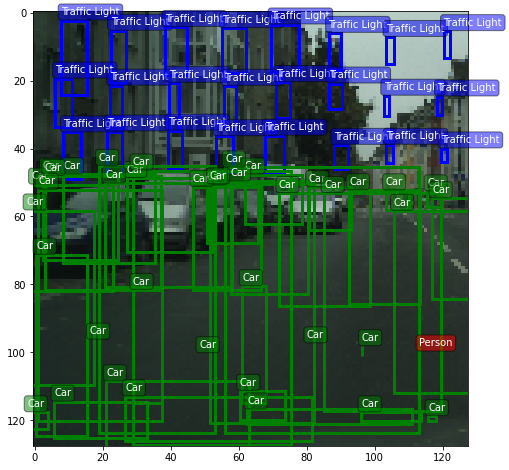

After Low Confidence suppression:


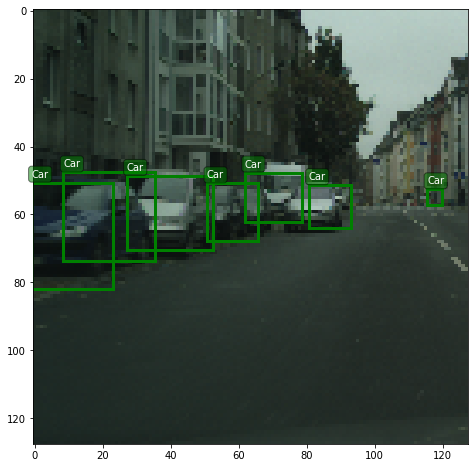

After Low confidence suppression and Non Maximal Suppression:


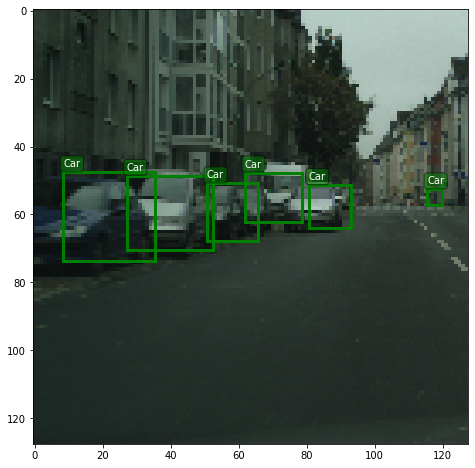

In [ ]:
#Transforms for preparing image for prediction
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(0.5,0.5)
     ]
)

#Selected idx for image
selected_idx = 12

#Image for prediction
selected_image = transform(images[selected_idx])
#Processed GT label
selected_gt_label = process_labels([raw_labels[selected_idx]])
#Predicted label
pred_label = new_model(selected_image.unsqueeze(0))[0].cpu().detach().numpy()
#Low confidence suppression
pred_low_conf_sup_label = low_confidence_suppression(pred_label.copy(), confidence_threshold = 0.6)
#Non maximal suppression
pred_low_conf_supr_nms_label = non_max_suppression(pred_low_conf_sup_label, nms_iou_threshold = 0.5)

print("Original ground truth:")
plot_image_with_boxes(convert_tensor_to_image(selected_image.cpu()), raw_labels[selected_idx])

print("Raw prediction:")
plot_image_with_boxes(convert_tensor_to_image(selected_image.cpu()), reconstruct_raw_labels(pred_label))

print("After Low Confidence suppression:")
pred_low_conf_sup_raw_label = reconstruct_raw_labels(pred_low_conf_sup_label)
plot_image_with_boxes(convert_tensor_to_image(selected_image.cpu()), pred_low_conf_sup_raw_label) 

print("After Low confidence suppression and Non Maximal Suppression:")
plot_image_with_boxes(convert_tensor_to_image(selected_image.cpu()), np.delete(pred_low_conf_supr_nms_label,1,axis=-1)) 

Here, the first image shows:- Original ground truth which represents the original labels of the image provided.
Second image represents the raw label predictions by the model trained.
Third image represents the output image after low confidence suppression where we got rid of predicted boxes with low objectness probability (Pr $<$0.6)
and the Fourth image is after low confidence suppression and NMS , is the final output which we have considered moving forward for calculation of precision, recall and mAP. 
We observed that a lot of redundant boxes were predicted by the model which were discarded following the two strategies of low confidence suppression and NMS.


### 1.7
**For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)**

Original ground truth:


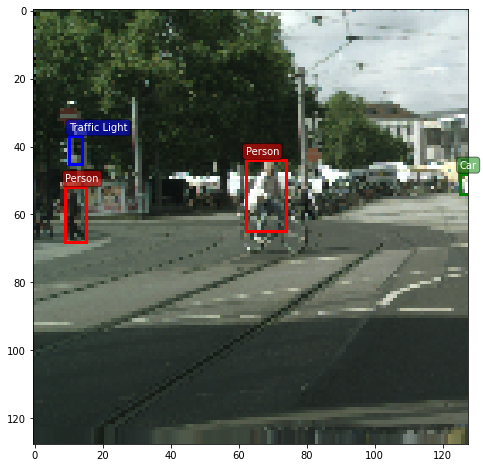

After Low confidence suppression and Non Maximal Suppression:


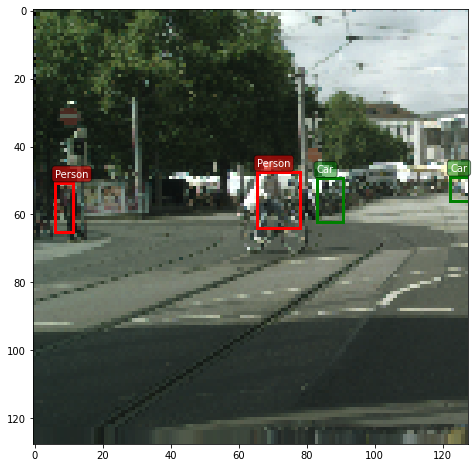

In [ ]:
#Transforms for preparing image for prediction
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(0.5,0.5)
     ]
)

#Selected idx for image
selected_idx = 216

#Image for prediction
selected_image = transform(images[selected_idx])
#Processed GT label
selected_gt_label = process_labels([raw_labels[selected_idx]])
#Predicted label
pred_label = new_model(selected_image.unsqueeze(0))[0].cpu().detach().numpy()
#Low confidence suppression
pred_low_conf_sup_label = low_confidence_suppression(pred_label.copy(), confidence_threshold = 0.6)
#Non maximal suppression
pred_low_conf_supr_nms_label = non_max_suppression(pred_low_conf_sup_label, nms_iou_threshold = 0.5)

#Max Confidence
max_conf = np.max(pred_label[:,:,0])

#Calculating precision and recall for all classes
preds_all, gts_all, max_conf = create_data_for_precision_recall(new_model)
recall_values, precision_values = precision_recall_curve(np.array(preds_all), targets=np.array(gts_all), max_confidence=max_conf, min_confidence_threshold = 0.5, num_confidence_intervals = 50)

print("Original ground truth:")
plot_image_with_boxes(convert_tensor_to_image(selected_image.cpu()), raw_labels[selected_idx])

print("After Low confidence suppression and Non Maximal Suppression:")
plot_image_with_boxes(convert_tensor_to_image(selected_image.cpu()), np.delete(pred_low_conf_supr_nms_label,1,axis=-1)) 

# print("After Low Confidence suppression:")
# pred_low_conf_sup_raw_label = reconstruct_raw_labels(pred_low_conf_sup_label)
# plot_image_with_boxes(convert_tensor_to_image(selected_image.cpu()), pred_low_conf_sup_raw_label) 


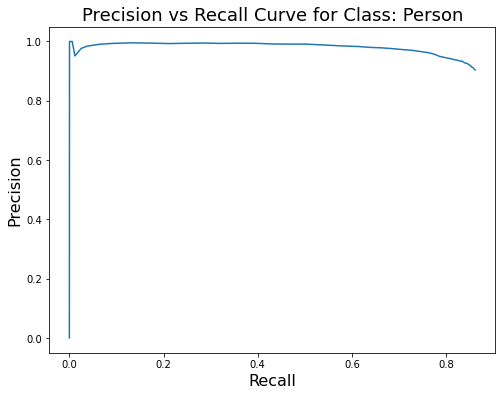

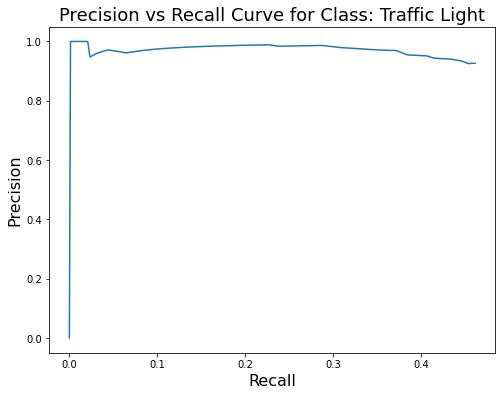

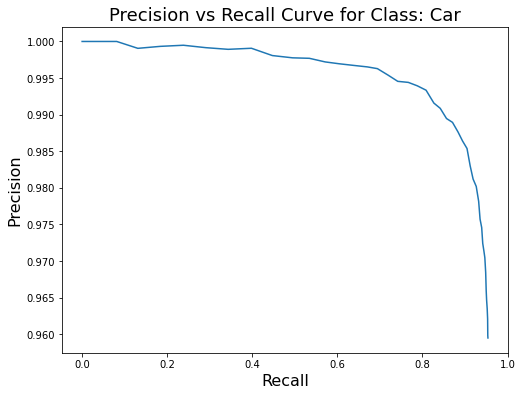

In [ ]:
title_map = {0 : "Person", 1:"Traffic Light", 2:"Car"}
cut_start = 1
for pred_class in [0,1,2]:
  
  recall_class = recall_values[pred_class]
  sort_idx = np.argsort(recall_class)
  precision_class = np.array(precision_values[pred_class])[sort_idx]
  recall_class = np.array(recall_class)[sort_idx]
  plt.figure(figsize = (8,6))
  plt.plot(recall_class[cut_start:], precision_class[cut_start:])
  plt.xlabel("Recall", fontsize=16)
  plt.ylabel("Precision", fontsize=16)
  plt.title(f"Precision vs Recall Curve for Class: {title_map[pred_class]}", fontsize=18)
  
  plt.show()
  # break
  

#### mAP of inference step:

In [ ]:
mAP_inf = mean_average_precision(np.array(preds_all), np.array(gts_all), max_conf, min_confidence_threshold = 0.6, num_confidence_intervals = 30)
print(mAP_inf)

0.6871460456886483


Here, we have taken an image which consists of all the three labels: cars, traffic lights and pedestrians. 
The first image shows the original ground truth labels where red bounding boxes are for pedestrians, blue bounding boxes around  traffic lights and green bounding boxes around cars.

Then , the second image is the output after low-confidence suppression and NMS done on the predictions given by the model.

We observed that model was able to detect the pedestrian and cars with the respective bounding boxes but wasn’t able to detect the traffic light which was also present in the original ground truth.  We think this might be happening because the bounding box around traffic light has small width, height and is smaller in size compared to the bounding boxes around pedestrians and cars.

The graphs above represents the precision/recall curves for all the classes in inference. The achieved mean Average Precision for inference stage is 68.71



### 1.8
**Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)**

When we started implementing Part B we initially faced a few challenges:
- To perform vectorization of  the code of calculation of Precious and Recall from IOU matrix. 
- To write the validation step code for mAP, because  in the validation step only a batch of images were being passed into the validation function where as the mAP function expected whole batch of images together

Though we found this challenging, we tried to take it one step at a time and we were able to cross the boat of hurdles after understanding the core concepts and found this to be great learning


Performance: In inference stage 30% of training data was used. The achieved mean Average Precision for inference stage is 68.71 and the mean Average Precision over entire data is 68.57. As reported by Gradescope we achieved per-class mAPs of:


*   Pedestrian    - 56.81
*   Traffic Light - 29.07
*   Car           - 69.1


Interesting Observations: 
1. We observed that bounding boxes with higher width and height were easily recognized by the model compared to the smaller bounding boxes. So, for instance  the cars had huge bounding boxes compared to the traffic lights in the original ground truth provided because it is huge object compared to the traffic light. So, model was easily able to detect cars and mAP of car object(69.1) was higher compared to traffic light and pedestrian. Pedestrian class have the lowest mAP(29.07). Thus we can say that  our model struggles with small objects such as traffic lights.

2. From the visualizations of raw label predictions output without performing NMS and low confidence suppression we observed that model might have learnt an implicit bias as the image showed that model predicted blue bounding boxes (traffic lights) at top most section of image, green color bounding boxes(cars) in the middle section of the image and red color bounding boxes(pedestrians) at the middle and lower most section of the image. This is a general picture from most of the images as traffic lights might be above and pedestrains might be walking over so they are in the lower section.



Further Improvements:

To further improve our model we are considering of-
1. Augmenting the dataset with more data or by image mix-up with geometry preserved alignment.
2. Use learning Rate Scheduler instead of fixed learning rate of 10e-3 and use different optimizers to check performance.
3. Use LeakyReLU instead of ReLU
4. By modifying the network architechture and making it more complex with more convolutional layers


## Calculating MAP for entire data

In [ ]:

def create_data_for_map(new_model):
#Creating the dataset

  from fastprogress import progress_bar

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(0.5,0.5)
      ]
  )

  processed_labels = np.asarray([process_labels([raw_labels[i]]) for i in range(len(raw_labels))])
  batch_size = 64
  class YOLODataset(Dataset):
      """TensorDataset with support of transforms.
      """
      def __init__(self, tensors, transform=None):
          # assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
          self.tensors = tensors
          self.transform = transform

      def __getitem__(self, index):
          x = self.tensors[0][index]
          if self.transform:
              x = self.transform(x)
          y = self.tensors[1][index]

          return x, y

      def __len__(self):
          # print(self.tensors[0].shape[0])
          return self.tensors[0].shape[0]

  # class YOLO

  train_proportion = 1.0
  train_idx = int(len(images) * train_proportion)
  train_dataset = YOLODataset(tensors=(images[:train_idx], processed_labels[:train_idx]), transform = transform)
  train_loader = DataLoader(train_dataset, batch_size = batch_size)

  
#Forming the entire validation set
  preds_all = []
  gts_all = []

  max_conf = 0
  for images_batch, labels_batch in progress_bar(train_loader):
    preds = new_model(images_batch)
    # print(torch.max(preds[:,:,:,0]))
    max_conf = max(max_conf,torch.max(preds[:,:,:,0]).cpu().detach().item() )
    preds_all.extend(preds.cpu().detach().numpy())
    gts_all.extend(labels_batch.cpu().detach().numpy())
  return preds_all, gts_all, max_conf

In [ ]:
preds_all, gts_all, max_conf = create_data_for_map(new_model)

In [ ]:
mean_average_precision(np.array(preds_all), np.array(gts_all), max_conf, min_confidence_threshold = 0.6, num_confidence_intervals = 30)

0.6857324432230608

In [ ]:
# #Creating final .npz file
# preds_test = low_confidence_suppression(np.array(preds_all))

# preds_nms = []
# for i,pred in enumerate(preds_test):
#   # if i%500 == 0:
#   #   print(i)
#   nms_pred = non_max_suppression(pred)
#   if len(nms_pred) == 0:
#     preds_nms.append(None)
#   else:
#     preds_nms.append(nms_pred)

# # np.savez("predictions3.npz",preds_nms)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


---

## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## My References:
- Anchor Boxes: https://medium.com/analytics-vidhya/you-only-look-once-yolo-implementing-yolo-in-less-than-30-lines-of-python-code-97fb9835bfd2#:~:text=What%20are%20anchor%20boxes
- Implementation reference: https://leiluoray.com/2018/11/10/Implementing-YOLOV3-Using-PyTorch/
- IOU: https://kikaben.com/object-detection-intersection-over-union/#chapter-3.2

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output. 

For part (a), your submission should consist of this file and a pdf report. This report can simply be a pdf version of this document. Example conversion code below.

**Please save before exporting!**

In [ ]:
# # !sudo apt-get update &> /dev/null
# # !sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended &> /dev/null
# !jupyter nbconvert --Application.log_level=10 --to pdf "/content/drive/MyDrive/Colab Notebooks/CIS 6800/HW2/cis6800-hw2_Shrivats_Anushka.ipynb"
